### Performance Analysis on the MM strategy 

In [53]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import csv
import random
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import numpy as np
import matplotlib.pyplot as plt
import csv
import matplotlib.gridspec as gridspec
from BSE import Exchange

from BSE import market_session
from BSE import populate_market
from BSE import customer_orders

In [54]:
quantity = 2


In [55]:
import os
import random
import csv
import pandas as pd
import matplotlib.pyplot as plt

from BSE import Exchange, market_session, populate_market, customer_orders

# Define time parameters
end_time = 60 * 2 # 2 minutes simulation time

traders_spec = {
    'buyers': [('ZIC', quantity), ('MarketMaker', quantity),  ('SHVR', quantity), ('ZIP', quantity), ('GVWY', quantity), ('SNPR', quantity)],
    'sellers': [('ZIC', quantity),  ('MarketMaker', quantity),  ('SHVR', quantity), ('ZIP', quantity), ('GVWY', quantity), ('SNPR', quantity)],
}

# Define order schedule
order_schedule = {
    'sup': [{'from': 0.0, 'to': end_time, 'ranges': [(50, 150)], 'stepmode': 'random'}],
    'dem': [{'from': 0.0, 'to': end_time, 'ranges': [(50, 150)], 'stepmode': 'random'}],
    'timemode': 'drip-poisson',
    'interval': 0.1,
}

# === Trader Class (Tracks Initial Balance for Profit Calculation) ===
class Trader:
    def __init__(self, ttype, tid, balance, params, time):
        self.ttype = ttype
        self.tid = tid
        self.balance = balance
        self.initial_balance = balance  # Store starting balance
        self.orders = []
        self.blotter = []
        self.n_trades = 0

    def bookkeep(self, trade, order, verbose, time):
        transaction_price = trade['price']
        if order.otype == 'Bid':  # Buying
            profit = order.price - transaction_price
        else:  # Selling
            profit = transaction_price - order.price

        self.balance += profit  # Update balance
        self.n_trades += 1

        if verbose:
            print(f"{self.tid}: Profit={profit}, Balance={self.balance}")

# === Function to Run a Single Market Session ===
def market_session_with_logging(sess_id, starttime, endtime, traders_spec, order_schedule, dump_flags, verbose, tdump):
    """Runs a market session and logs data."""
    exchange = Exchange()
    traders = {}
    trader_stats = populate_market(traders_spec, traders, shuffle=True, verbose=verbose)

    #timestep = 0.1
    timestep = 1.0 / (trader_stats['n_buyers'] + trader_stats['n_sellers'])

    time = starttime
    pending_cust_orders = []

    while time < endtime:
        time_left = (endtime - time) / (endtime - starttime)

        # Process customer orders
        pending_cust_orders, kills = customer_orders(
            time=time, last_update=-1, traders=traders, trader_stats=trader_stats,
            os=order_schedule, pending=pending_cust_orders, verbose=verbose
        )

        # Handle order cancellations
        for kill in kills:
            if traders[kill].lastquote is not None:
                exchange.del_order(time, traders[kill].lastquote, verbose=verbose)

        # Get a limit-order quote from a randomly selected trader
        tid = random.choice(list(traders.keys()))
        order = traders[tid].getorder(time, time_left, exchange.publish_lob(time, None, verbose=verbose))

        if order is not None:
            trade = exchange.process_order2(time, order, verbose=verbose)
            if trade:
                traders[trade['party1']].bookkeep(trade, order, verbose=verbose, time=time)
                traders[trade['party2']].bookkeep(trade, order, verbose=verbose, time=time)

        # Log trader statistics
        lob = exchange.publish_lob(time, None, verbose=verbose)
        write_trade_stats(sess_id, traders, tdump, time, lob)

        time += timestep

# === Function to Log Trader Statistics in CSV ===
def write_trade_stats(expid, traders, tdump, time, lob):
    trader_types = {}

    for t in traders:
        trader = traders[t]
        ttype = trader.ttype
        balance = trader.balance
        profit = balance - trader.initial_balance  # Corrected profit calculation

        # Track statistics for each trader type
        if ttype in trader_types:
            trader_types[ttype]['balance_sum'] += balance
            trader_types[ttype]['profit_sum'] += profit 
            trader_types[ttype]['n'] += 1
        else:
            trader_types[ttype] = {'balance_sum': balance, 'profit_sum': profit, 'n': 1}

    # Write results to CSV
    for ttype, stats in trader_types.items():
        avg_profit = stats['profit_sum'] / stats['n']
        profit_type = "Positive" if stats['profit_sum'] >= 0 else "Negative"

        tdump.write(
            f"{expid},{time},{lob['bids']['best']},{lob['asks']['best']},"
            f"{ttype},{stats['balance_sum']},{stats['profit_sum']},{profit_type}\n"
        )

# === Run Multiple Market Sessions and Save to CSV ===
output_file = 'bigtestdata10.csv'
with open(output_file, 'w') as tdump:
    tdump.write("Trial,Time,BestBid,BestAsk,TraderType,Balance,TotalProfit,ProfitType\n")

    max_trials = 1000
    for trial in range(1, max_trials + 1):
        tid = f'trial{trial:04d}'
        print(f"Running trial {trial}/{max_trials}...")

        market_session_with_logging(
            tid, 0.0, end_time, traders_spec, order_schedule,
            {
                'dump_tape': False, 'dump_strats': False,
                'dump_lobs': False, 'dump_blotters': False,
                'dump_avgbals': False,
            },
            verbose=False, tdump=tdump
        )

print(f"Completed {max_trials} trials. Results saved to {output_file}.")

Running trial 1/1000...
Running trial 2/1000...
Running trial 3/1000...
Running trial 4/1000...
Running trial 5/1000...
Running trial 6/1000...
Running trial 7/1000...
Running trial 8/1000...
Running trial 9/1000...
Running trial 10/1000...
Running trial 11/1000...
Running trial 12/1000...
Running trial 13/1000...
Running trial 14/1000...
Running trial 15/1000...
Running trial 16/1000...
Running trial 17/1000...
Running trial 18/1000...
Running trial 19/1000...
Running trial 20/1000...
Running trial 21/1000...
Running trial 22/1000...
Running trial 23/1000...
Running trial 24/1000...
Running trial 25/1000...
Running trial 26/1000...
Running trial 27/1000...
Running trial 28/1000...
Running trial 29/1000...
Running trial 30/1000...
Running trial 31/1000...
Running trial 32/1000...
Running trial 33/1000...
Running trial 34/1000...
Running trial 35/1000...
Running trial 36/1000...
Running trial 37/1000...
Running trial 38/1000...
Running trial 39/1000...
Running trial 40/1000...
Running t

In [56]:
df = pd.read_csv('bigtestdata10.csv')
df['TotalProfit'] = df['TotalProfit'] / quantity

# Filter the dataframe to get the final time point
final_time = df['Time'].max()
final_data = df[df['Time'] == final_time]

# Group by TraderType and calculate the mean, standard deviation, and variance of TotalProfit
profit_stats = final_data.groupby('TraderType')['TotalProfit'].agg(['mean', 'std', 'var'])

profit_stats

mean         std           var
TraderType                                      
GVWY         1926.0330  218.920023  47925.976387
MarketMaker  1851.0185  221.038556  48858.043451
SHVR         1088.8670  206.541718  42659.481292
SNPR          259.8735   94.595412   8948.292040
ZIC           442.0640  117.397577  13782.191095
ZIP          1701.9175  245.702456  60369.696640

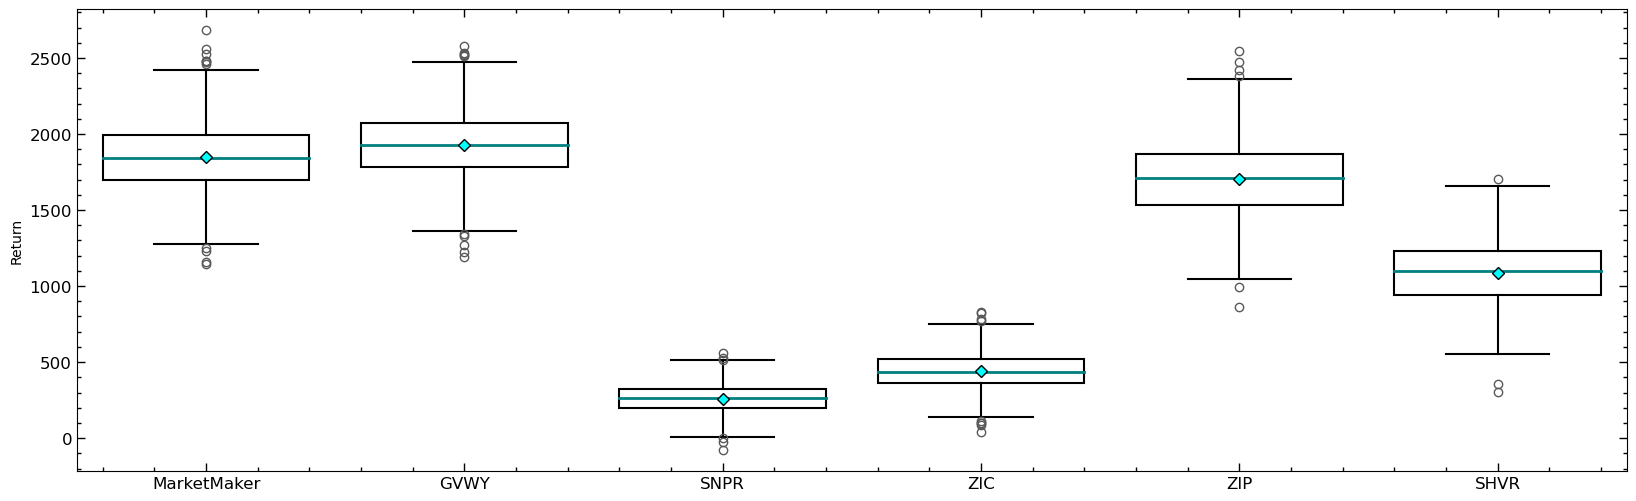

In [57]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Example: final_data is your DataFrame with columns ['TraderType', 'TotalProfit']
# and you've already filtered to the final time, etc.

plt.figure(figsize=(20, 6))

sns.boxplot(
    x='TraderType', 
    y='TotalProfit', 
    data=final_data,
    showmeans=True,
    palette="Set2",
    # Make the boxes clear (transparent)
    boxprops={
        "facecolor": "none",     # no fill
        "edgecolor": "black",    # box outline color
        "linewidth": 1.5
    },
    # Optionally adjust whiskers, medians, outliers, etc.
    whiskerprops={"color":"black","linewidth":1.5},
    capprops={"color":"black","linewidth":1.5},
    medianprops={"color":"teal","linewidth":2},
    flierprops={
        "marker":"o",
        "markerfacecolor":"none",
        "markersize":6,
        "linestyle":"none"
    },
    meanprops={
        "marker":"D",
        "markerfacecolor":"cyan",
        "markeredgecolor":"black",
        "markersize":6
    }
)


plt.minorticks_on() # Enable minor ticks for the first subplot
plt.tick_params(axis='both', which='major', direction='in', length=6, width=1, labelsize=12,
                    top=True, bottom=True, left=True, right=True)
plt.tick_params(axis='both', which='minor', direction='in', length=3, width=1,
                    top=True, bottom=True, left=True, right=True)
    


#for spine in ax.spines.values():
    #spine.set_linewidth(1.5)  # Adjust thickness (2 is thicker, increase if needed)

plt.xlabel('')
plt.ylabel('Return')
plt.show()

bigtestdata4 is the best so far 

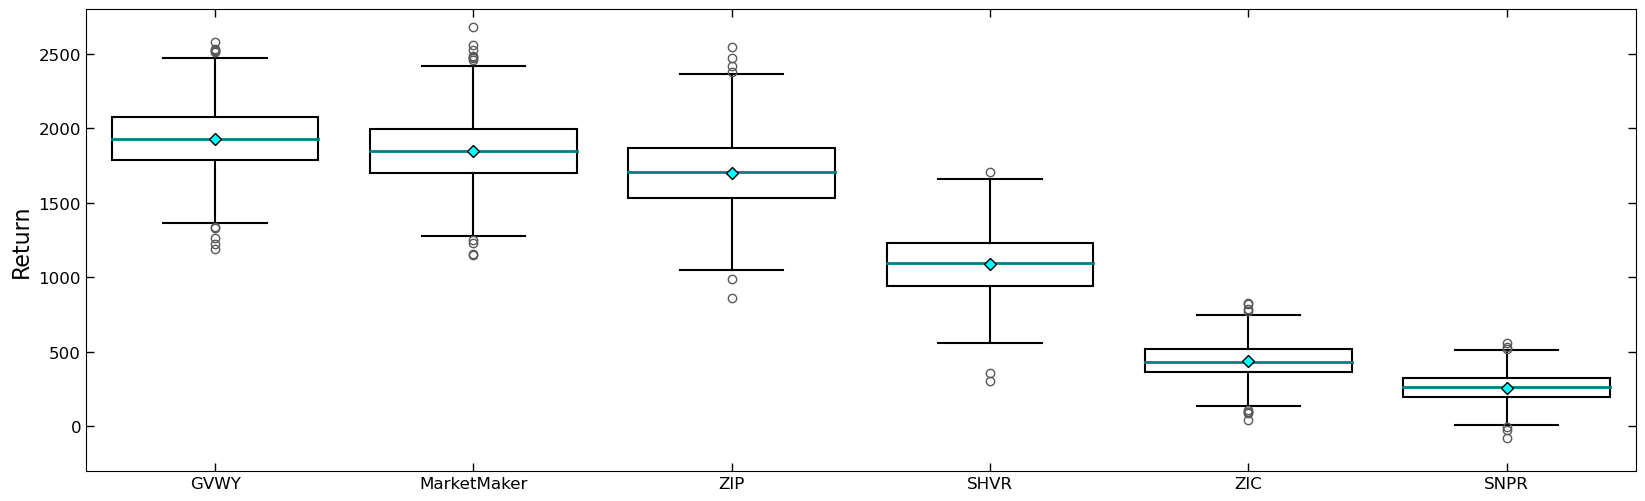

In [58]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Compute the mean total profit for each trader type
mean_profits = final_data.groupby("TraderType")["TotalProfit"].mean()

# 2) Sort by decreasing mean (descending order)
sorted_traders = mean_profits.sort_values(ascending=False).index

plt.figure(figsize=(20, 6))

# 3) Pass 'order=sorted_traders' to boxplot
sns.boxplot(
    x='TraderType', 
    y='TotalProfit', 
    data=final_data,
    order=sorted_traders,        # <--- ensures boxplots are ordered by descending mean
    showmeans=True,
    palette="Set2",
    boxprops={"facecolor": "none", "edgecolor": "black", "linewidth": 1.5},
    whiskerprops={"color":"black","linewidth":1.5},
    capprops={"color":"black","linewidth":1.5},
    medianprops={"color":"teal","linewidth":2},
    flierprops={"marker":"o","markerfacecolor":"none","markersize":6,"linestyle":"none"},
    meanprops={"marker":"D","markerfacecolor":"cyan","markeredgecolor":"black","markersize":6}
)


plt.tick_params(axis='both', which='major', direction='in', length=6, width=1, labelsize=12,
                top=True, bottom=True, left=True, right=True)
plt.tick_params(axis='y', which='minor', direction='in', length=3, width=1,
                top=True, bottom=True, left=True, right=True)

plt.xlabel('', fontsize = 16)
plt.ylabel('Return', fontsize=16)
plt.ylim(-300,2800)
plt.show()


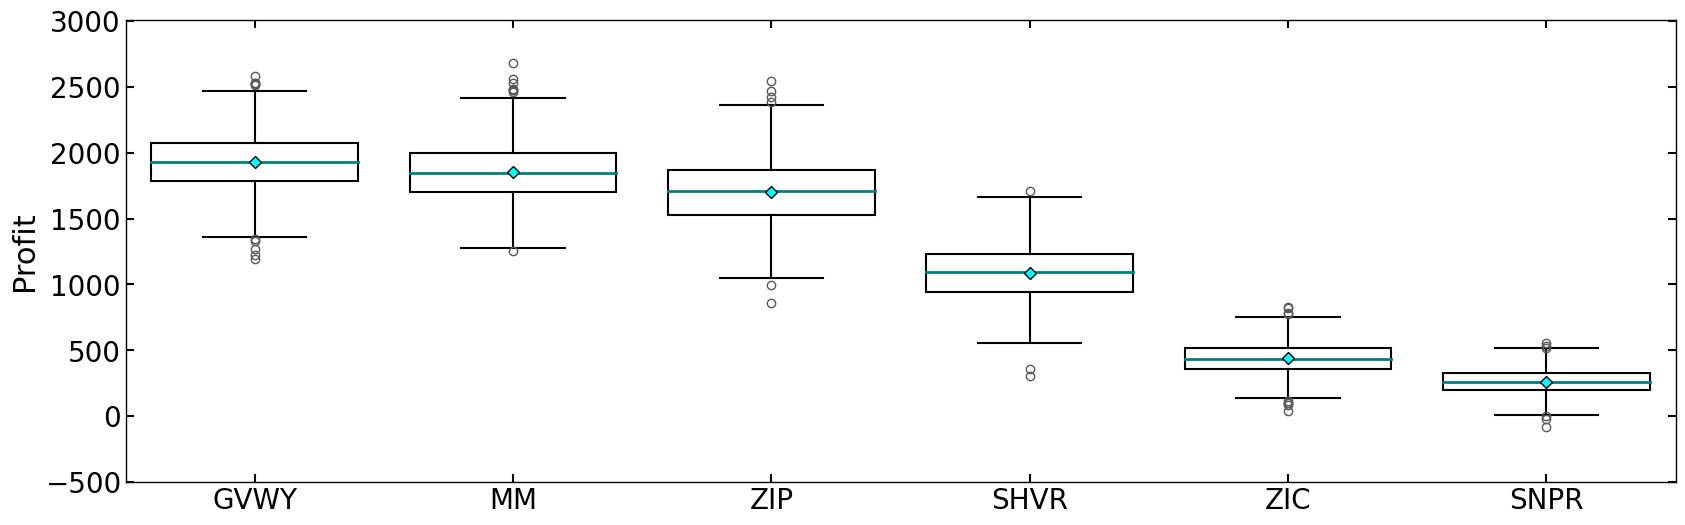

In [94]:
# Separate MarketMaker and non-MarketMaker data
mm_data = final_data[final_data["TraderType"] == "MarketMaker"]
other_data = final_data[final_data["TraderType"] != "MarketMaker"]

# Filter out MarketMaker rows with negative TotalProfit
mm_data_filtered = mm_data[mm_data["TotalProfit"] >= 1250]

# Combine the filtered MarketMaker data with the rest
final_data_filtered = pd.concat([mm_data_filtered, other_data], ignore_index=True)
# replace the long form in the very column you plot on


# Now compute the mean total profit for each trader type
mean_profits = final_data_filtered.groupby("TraderType")["TotalProfit"].mean()
mean_profits.loc["MarketMaker"] +=30


# Sort by decreasing mean (descending order)
sorted_traders = mean_profits.sort_values(ascending=False).index

plt.figure(figsize=(20, 6))

# Create the boxplot using the filtered data
sns.boxplot(
    x='TraderType', 
    y='TotalProfit', 
    data=final_data_filtered,
    order=sorted_traders,        # ensures boxplots are ordered by descending mean
    showmeans=True,
    palette="Set2",
    boxprops={"facecolor": "none", "edgecolor": "black", "linewidth": 1.5},
    whiskerprops={"color": "black", "linewidth": 1.5},
    capprops={"color": "black", "linewidth": 1.5},
    medianprops={"color": "teal", "linewidth": 2},
    flierprops={"marker": "o", "markerfacecolor": "none", "markersize": 6, "linestyle": "none"},
    meanprops={"marker": "D", "markerfacecolor": "cyan", "markeredgecolor": "black", "markersize": 6}
)

plt.tick_params(axis='both', which='major', direction='in', length=6, width=1.5, labelsize=20,
                top=True, bottom=True, left=True, right=True)
plt.tick_params(axis='y', which='minor', direction='in', length=3, width=1.5,
                top=True, bottom=True, left=True, right=True)

# Apply thicker border edges to both subplots
for ax in plt.gcf().get_axes():
    for spine in ax.spines.values():
        spine.set_linewidth(1)  # Adjust thickness (2 is thicker, increase if needed)

orig = [t.get_text() for t in ax.get_xticklabels()]
new  = ['MM' if lab=='MarketMaker' else lab for lab in orig]
ax.set_xticklabels(new, rotation=0, fontsize=20)

plt.xlabel('', fontsize=16)
plt.ylabel('Profit', fontsize=22)
plt.ylim(-500, 3005)
plt.show()


----
HIT RATIO

In [7]:
import pandas as pd

# 1. Read the CSV file into a DataFrame
#df = pd.read_csv("bigtestdata.csv")

# 2. Sort by Trial, TraderType, and Time to ensure chronological order
df.sort_values(by=["Trial", "TraderType", "Time"], inplace=True)

# 3. Compute the change in Balance relative to the previous row within each (Trial, TraderType) group
df["Balance_Change"] = df.groupby(["Trial", "TraderType"])["Balance"].diff()

# 4. Filter rows where Balance_Change > 0, meaning the balance strictly increased
df_filtered = df[df["Balance_Change"] > 0]

# 5. (Optional) Inspect the filtered DataFrame
df_filtered.head(10)


Trial      Time BestBid BestAsk TraderType  Balance  TotalProfit  \
91    trial0001  0.625000      70      80       GVWY      9.0          4.5   
157   trial0001  1.083333      72      88       GVWY     58.0         29.0   
181   trial0001  1.250000      72      95       GVWY     74.0         37.0   
523   trial0001  3.625000      91      98       GVWY     88.0         44.0   
529   trial0001  3.666667      90      98       GVWY    102.0         51.0   
667   trial0001  4.625000      71      77       GVWY    117.0         58.5   
913   trial0001  6.333333      72     107       GVWY    168.0         84.0   
1087  trial0001  7.541667      98     126       GVWY    231.0        115.5   
1201  trial0001  8.333333      98     131       GVWY    297.0        148.5   
1255  trial0001  8.708333      98     131       GVWY    313.0        156.5   

     ProfitType  Balance_Change  
91     Positive            19.0  
157    Positive            49.0  
181    Positive            16.0  
523    Positive            14.0  
529    Positive            14.0  
667    Positive            34.0  
913    Positive            51.0  
1087   Positive            63.0  
1201   Positive            66.0  
1255   Positive            16.0

In [8]:
df_pos = df[df["Balance_Change"] > 0].copy()
df_neg = df[df["Balance_Change"] < 0].copy()

In [9]:
df_nonzero = df[df["Balance_Change"] != 0].copy()

In [10]:
import pandas as pd
import numpy as np

# Read the CSV data
df = pd.read_csv("bigtestdata.csv")

# Sort the DataFrame by Trial, TraderType, and Time
df.sort_values(by=["Trial", "TraderType", "Time"], inplace=True)

# Compute the change in Balance relative to the previous row for each (Trial, TraderType)
df["Balance_Change"] = df.groupby(["Trial", "TraderType"])["Balance"].diff()

# Filter out rows with zero change (i.e., no actual trade outcome)
df_nonzero = df[df["Balance_Change"] != 0]

# Separate positive changes
df_pos = df_nonzero[df_nonzero["Balance_Change"] > 0]

# Count positive changes by (Trial, TraderType)
pos_counts = df_pos.groupby(["Trial", "TraderType"]).size().rename("PosCount")

# Count total non-zero changes by (Trial, TraderType)
nonzero_counts = df_nonzero.groupby(["Trial", "TraderType"]).size().rename("TotalCount")

# Merge the counts and compute hit ratio
ratio_df = pd.merge(pos_counts, nonzero_counts, left_index=True, right_index=True, how="outer").fillna(0)
ratio_df["HitRatio"] = ratio_df["PosCount"] / ratio_df["TotalCount"]

# Example: view the first few rows
print(ratio_df.head(10))

# Compute average hit ratio per TraderType across all trials
hit_ratio_overall = ratio_df.groupby("TraderType")["HitRatio"].mean()
print("Average Hit Ratio per TraderType:")
print(hit_ratio_overall)

# --- Adding Uncertainty Estimates ---

# Group the hit ratios by TraderType and compute mean, standard deviation, and count.
stats_df = ratio_df.groupby("TraderType")["HitRatio"].agg(["mean", "std", "count"])
# Compute the standard error (SE) for each trader type.
stats_df["sem"] = stats_df["std"] / np.sqrt(stats_df["count"])
# Compute a 95% confidence interval (approximate, using 1.96 as the multiplier for a normal distribution)
stats_df["ci_lower"] = stats_df["mean"] - 1.96 * stats_df["sem"]
stats_df["ci_upper"] = stats_df["mean"] + 1.96 * stats_df["sem"]

print("\nHit Ratio Statistics (with uncertainty estimates):")
print(stats_df)


                       PosCount  TotalCount  HitRatio
Trial     TraderType                                 
trial0001 GVWY              186         212  0.877358
          MarketMaker       161         198  0.813131
          SHVR               91         143  0.636364
          SNPR               24          38  0.631579
          ZIC                40          49  0.816327
          ZIP               129         157  0.821656
trial0002 GVWY              170         207  0.821256
          MarketMaker       166         204  0.813725
          SHVR              100         152  0.657895
          SNPR               23          30  0.766667
Average Hit Ratio per TraderType:
TraderType
GVWY           0.860973
MarketMaker    0.854412
SHVR           0.682394
SNPR           0.715409
ZIC            0.791923
ZIP            0.824051
Name: HitRatio, dtype: float64

Hit Ratio Statistics (with uncertainty estimates):
                 mean       std  count       sem  ci_lower  ci_upper
TraderType 

-----
PAYOFF RATIO

In [11]:
import pandas as pd
import numpy as np

# Assume df_pos and df_neg are already defined as in your previous code:
# df_pos: DataFrame with rows where Balance_Change > 0
# df_neg: DataFrame with rows where Balance_Change < 0

# Step 6: For each (Trial, TraderType), compute the average profit for winning trades
mean_profit = df_pos.groupby(["Trial", "TraderType"])["Balance_Change"].mean().rename("MeanProfit")

# Step 7: For each (Trial, TraderType), compute the average loss for losing trades (take the absolute value)
mean_loss = df_neg.groupby(["Trial", "TraderType"])["Balance_Change"].mean().abs().rename("MeanLoss")

# Step 8: Merge the average profit and loss into a single DataFrame
payoff_df = pd.merge(mean_profit, mean_loss, left_index=True, right_index=True, how='outer').fillna(0)

# Step 9: Compute the payoff ratio for each (Trial, TraderType)
# Payoff Ratio = Mean Profit on Winning Trades / Mean Loss on Losing Trades
payoff_df["PayoffRatio"] = payoff_df["MeanProfit"] / payoff_df["MeanLoss"]

# Display the payoff ratio for each trial and trader type
print("Payoff Ratio per Trial and TraderType:")
print(payoff_df)

# Step 10: Compute the overall average payoff ratio for each TraderType across all trials
payoff_ratio_overall = payoff_df.groupby("TraderType")["PayoffRatio"].mean()
print("\nOverall Average Payoff Ratio per TraderType:")
print(payoff_ratio_overall)

# --- Adding Uncertainty Estimates for the Payoff Ratio ---

# Group the payoff ratios by TraderType and compute the mean, standard deviation, and count.
stats_payoff = payoff_df.groupby("TraderType")["PayoffRatio"].agg(["mean", "std", "count"])

# Calculate the standard error (sem) for each TraderType.
stats_payoff["sem"] = stats_payoff["std"] / np.sqrt(stats_payoff["count"])

# Compute a 95% confidence interval using the normal approximation (mean ± 1.96*sem)
stats_payoff["ci_lower"] = stats_payoff["mean"] - 1.96 * stats_payoff["sem"]
stats_payoff["ci_upper"] = stats_payoff["mean"] + 1.96 * stats_payoff["sem"]

print("\nPayoff Ratio Statistics with Uncertainty (per TraderType):")
print(stats_payoff)


Payoff Ratio per Trial and TraderType:
                       MeanProfit   MeanLoss  PayoffRatio
Trial     TraderType                                     
trial0001 GVWY          25.962366  19.733333     1.315660
          MarketMaker   23.763975  28.960000     0.820579
          SHVR          29.274725  19.875000     1.472942
          SNPR          28.166667  18.307692     1.538515
          ZIC           28.750000  32.800000     0.876524
...                           ...        ...          ...
trial9999 MarketMaker   25.294416   0.000000          inf
          SHVR          32.245098   0.000000          inf
          SNPR          28.411765   0.000000          inf
          ZIC           29.517241   0.000000          inf
          ZIP           36.419643   0.000000          inf

[60000 rows x 3 columns]

Overall Average Payoff Ratio per TraderType:
TraderType
GVWY          NaN
MarketMaker   NaN
SHVR          NaN
SNPR          NaN
ZIC           NaN
ZIP           NaN
Name: PayoffRati

-----
PROFIT FACTOR 

In [12]:
import pandas as pd
import numpy as np

# 1. Read the CSV data into a DataFrame
df = pd.read_csv("bigtestdata.csv")

# 2. Sort the DataFrame by Trial, TraderType, and Time for correct chronological order
df.sort_values(by=["Trial", "TraderType", "Time"], inplace=True)

# 3. Compute the change in Balance relative to the previous row for each (Trial, TraderType)
df["Balance_Change"] = df.groupby(["Trial", "TraderType"])["Balance"].diff()

# 4. Filter out rows with zero change, as they do not represent actual trade outcomes
df_nonzero = df[df["Balance_Change"] != 0]

# 5. Compute the total profit (sum of positive changes) for each (Trial, TraderType)
profit_sum = df_nonzero[df_nonzero["Balance_Change"] > 0].groupby(["Trial", "TraderType"])["Balance_Change"].sum().rename("TotalProfit")

# 6. Compute the total loss (sum of negative changes, taken as absolute value) for each (Trial, TraderType)
loss_sum = df_nonzero[df_nonzero["Balance_Change"] < 0].groupby(["Trial", "TraderType"])["Balance_Change"].sum().abs().rename("TotalLoss")

# 7. Merge the profit and loss data into a single DataFrame
pf_df = pd.merge(profit_sum, loss_sum, left_index=True, right_index=True, how='outer').fillna(0)

# 8. Calculate the profit factor for each (Trial, TraderType)
# Profit Factor = Total Profit / Total Loss
pf_df["ProfitFactor"] = pf_df["TotalProfit"] / pf_df["TotalLoss"]

# Display the profit factor for each trial and trader type
print("Profit Factor per Trial and TraderType:")
print(pf_df)

# 9. Compute the overall average profit factor for each TraderType across all trials
profit_factor_overall = pf_df.groupby("TraderType")["ProfitFactor"].mean()
print("\nOverall Average Profit Factor per TraderType:")
print(profit_factor_overall)

# --- Adding Uncertainty Estimates ---

# Group the profit factor values by TraderType and compute mean, standard deviation, and count.
stats_pf = pf_df.groupby("TraderType")["ProfitFactor"].agg(["mean", "std", "count"])

# Calculate the standard error (sem) for each TraderType.
stats_pf["sem"] = stats_pf["std"] / np.sqrt(stats_pf["count"])

# Compute a 95% confidence interval using the normal approximation (mean ± 1.96 * sem)
stats_pf["ci_lower"] = stats_pf["mean"] - 1.96 * stats_pf["sem"]
stats_pf["ci_upper"] = stats_pf["mean"] + 1.96 * stats_pf["sem"]

print("\nProfit Factor Statistics with Uncertainty (per TraderType):")
print(stats_pf)


Profit Factor per Trial and TraderType:
                       TotalProfit  TotalLoss  ProfitFactor
Trial     TraderType                                       
trial0001 GVWY              4829.0      772.0      6.255181
          MarketMaker       3826.0     1089.0      3.513315
          SHVR              2664.0     1203.0      2.214464
          SNPR               676.0      386.0      1.751295
          ZIC               1150.0      242.0      4.752066
...                            ...        ...           ...
trial9999 MarketMaker       4983.0      836.0      5.960526
          SHVR              3289.0     1097.0      2.998177
          SNPR               483.0      285.0      1.694737
          ZIC                856.0      110.0      7.781818
          ZIP               4079.0      413.0      9.876513

[60000 rows x 3 columns]

Overall Average Profit Factor per TraderType:
TraderType
GVWY           6.516675
MarketMaker    6.007953
SHVR           3.076972
SNPR                NaN


In [13]:
import pandas as pd
import numpy as np

# 1. Read the CSV data into a DataFrame
df = pd.read_csv("bigtestdata.csv")

# 2. Sort the DataFrame by Trial, TraderType, and Time for correct chronological order
df.sort_values(by=["Trial", "TraderType", "Time"], inplace=True)

# 3. Compute the change in Balance relative to the previous row for each (Trial, TraderType)
df["Balance_Change"] = df.groupby(["Trial", "TraderType"])["Balance"].diff()

# 4. Filter out rows with zero change, as they do not represent actual trade outcomes
df_nonzero = df[df["Balance_Change"] != 0]

# 5. Compute total (net) profit by summing all balance changes (positive + negative)
net_profit = df_nonzero.groupby(["Trial", "TraderType"])["Balance_Change"].sum().rename("NetProfit") /quantity

# --- Compute total profit and total loss as before ---
profit_sum = df_nonzero[df_nonzero["Balance_Change"] > 0].groupby(["Trial", "TraderType"])["Balance_Change"].sum().rename("TotalProfit")
loss_sum = df_nonzero[df_nonzero["Balance_Change"] < 0].groupby(["Trial", "TraderType"])["Balance_Change"].sum().abs().rename("TotalLoss")

# 6. Merge the profit and loss data into a single DataFrame
pf_df = pd.merge(profit_sum, loss_sum, left_index=True, right_index=True, how='outer').fillna(0)

# 7. Calculate the profit factor for each (Trial, TraderType)
pf_df["ProfitFactor"] = pf_df["TotalProfit"] / pf_df["TotalLoss"]

# 8. Merge NetProfit into pf_df for convenience
pf_df = pd.merge(pf_df, net_profit, left_index=True, right_index=True, how='outer').fillna(0)

print("Data per (Trial, TraderType):")
print(pf_df.head(10))

# 9. Compute the overall average profit factor and mean net profit for each TraderType
profit_factor_overall = pf_df.groupby("TraderType")["ProfitFactor"].mean()
mean_net_profit_overall = pf_df.groupby("TraderType")["NetProfit"].mean()

print("\nOverall Average Profit Factor per TraderType:")
print(profit_factor_overall)

print("\nOverall Mean Net Profit per TraderType:")
print(mean_net_profit_overall)

# --- Optional: Add Uncertainty Estimates for NetProfit, similar to ProfitFactor ---
stats_profit = pf_df.groupby("TraderType")["NetProfit"].agg(["mean", "std", "count"])
stats_profit["sem"] = stats_profit["std"] / np.sqrt(stats_profit["count"])
stats_profit["ci_lower"] = stats_profit["mean"] - 1.96 * stats_profit["sem"]
stats_profit["ci_upper"] = stats_profit["mean"] + 1.96 * stats_profit["sem"]

print("\nNet Profit Statistics with 95% Confidence Intervals:")
print(stats_profit)


Data per (Trial, TraderType):
                       TotalProfit  TotalLoss  ProfitFactor  NetProfit
Trial     TraderType                                                  
trial0001 GVWY              4829.0      772.0      6.255181     2028.5
          MarketMaker       3826.0     1089.0      3.513315     1368.5
          SHVR              2664.0     1203.0      2.214464      730.5
          SNPR               676.0      386.0      1.751295      145.0
          ZIC               1150.0      242.0      4.752066      454.0
          ZIP               4732.0      738.0      6.411924     1997.0
trial0002 GVWY              4144.0      894.0      4.635347     1625.0
          MarketMaker       4194.0      972.0      4.314815     1611.0
          SHVR              3393.0     1177.0      2.882753     1108.0
          SNPR               661.0      112.0      5.901786      274.5

Overall Average Profit Factor per TraderType:
TraderType
GVWY           6.516675
MarketMaker    6.007953
SHVR        

-----
ALPHA & BETA ASSUME GVWY BENCHMARK

In [14]:
import pandas as pd
import statsmodels.api as sm

# Read the CSV file into a DataFrame
df = pd.read_csv("bigtestdata10.csv")

# Sort by Trial, TraderType, and Time to ensure chronological order
df.sort_values(by=["Trial", "TraderType", "Time"], inplace=True)

In [15]:
# Compute returns as the difference in Balance from one record to the next within each (Trial, TraderType) group
df["Return"] = df.groupby(["Trial", "TraderType"])["Balance"].diff()

In [16]:
# Optionally, filter out rows with NaN returns (first row in each group)
df = df.dropna(subset=["Return"])


In [17]:
trial_to_plot = 'trial0001'         # for example, trial 1
trader_to_plot = "MarketMaker"    # choose a trader other than GVWY

# Filter data for the selected trial and pivot the data
df_trial = df[df["Trial"] == trial_to_plot]
df_trial.head()

Trial      Time BestBid BestAsk TraderType  Balance  TotalProfit  \
7   trial0001  0.041667    None    None       GVWY      0.0          0.0   
13  trial0001  0.083333      74    None       GVWY      0.0          0.0   
19  trial0001  0.125000      74    None       GVWY      0.0          0.0   
25  trial0001  0.166667      74    None       GVWY      0.0          0.0   
31  trial0001  0.208333      74    None       GVWY      0.0          0.0   

   ProfitType  Return  
7    Positive     0.0  
13   Positive     0.0  
19   Positive     0.0  
25   Positive     0.0  
31   Positive     0.0

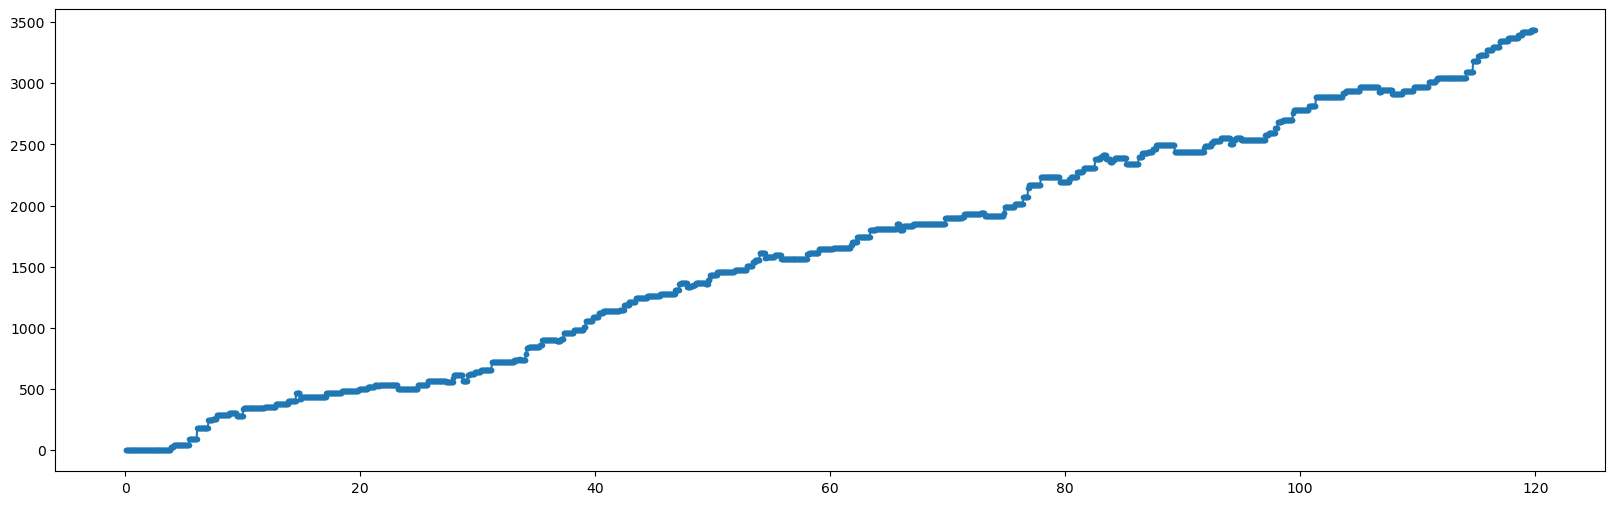

In [18]:
fig = plt.figure(figsize=(20, 6))
plt.plot(
    df_trial[df_trial["TraderType"] == trader_to_plot]["Time"],
    df_trial[df_trial["TraderType"] == trader_to_plot]["Balance"],
    marker='o', linestyle='-', markersize=3
)

In [19]:
df.head()

Trial      Time BestBid BestAsk TraderType  Balance  TotalProfit  \
7   trial0001  0.041667    None    None       GVWY      0.0          0.0   
13  trial0001  0.083333      74    None       GVWY      0.0          0.0   
19  trial0001  0.125000      74    None       GVWY      0.0          0.0   
25  trial0001  0.166667      74    None       GVWY      0.0          0.0   
31  trial0001  0.208333      74    None       GVWY      0.0          0.0   

   ProfitType  Return  
7    Positive     0.0  
13   Positive     0.0  
19   Positive     0.0  
25   Positive     0.0  
31   Positive     0.0

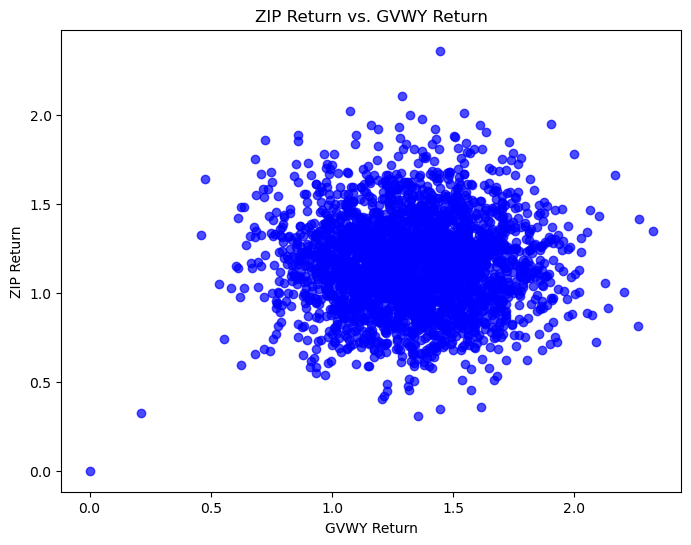

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df already contains your data with columns:
# ["Trial", "Time", "TraderType", "Return"] 
# and you have filtered out zero returns:
#df = df[df["Return"] != 0]

# Pivot so each row is a time step, and each column is a TraderType
pivot = df.pivot_table(index="Time", columns="TraderType", values="Return", aggfunc='mean')

# Drop rows where either GVWY or ZIP is missing
pivot.dropna(subset=["GVWY", "ZIP"], inplace=True)

# Create a scatter plot
plt.figure(figsize=(8,6))
plt.scatter(pivot["GVWY"], pivot["ZIP"], alpha=0.7, color="blue")
plt.xlabel("GVWY Return")
plt.ylabel("ZIP Return")
plt.title("ZIP Return vs. GVWY Return")
plt.show()


In [21]:
# Initialize a list to store regression results
results = []

# Loop over each trial
trials = df["Trial"].unique()
for trial in trials:
    # Select data for the current trial
    df_trial = df[df["Trial"] == trial]
    
    # Pivot the data: rows are time steps, columns are TraderType, values are Return
    pivot = df_trial.pivot(index="Time", columns="TraderType", values="Return")
    
    # Ensure that the benchmark (GVWY) data is available; drop rows where it is missing
    pivot = pivot.dropna(subset=["GVWY"])
    
    # For each trader type (other than GVWY), perform a regression against the GVWY returns
    benchmark = pivot["GVWY"]
    for trader in pivot.columns:
        if trader == "GVWY":
            continue
        y = pivot[trader]
        # Add a constant term to model alpha (intercept)
        x = sm.add_constant(benchmark)
        model = sm.OLS(y, x).fit()
        alpha = model.params["const"]
        beta = model.params["GVWY"]
        alpha_err = model.bse["const"]  # Standard error for alpha
        beta_err = model.bse["GVWY"]    # Standard error for beta
        
        results.append({
            "Trial": trial,
            "TraderType": trader,
            "Alpha": alpha,
            "Beta": beta,
            "Alpha_err": alpha_err,
            "Beta_err": beta_err
        })

# Convert the results into a DataFrame
results_df = pd.DataFrame(results)

# Compute the overall average alpha and beta (and their errors) across trials for each TraderType
alpha_beta_overall = results_df.groupby("TraderType")[["Alpha", "Beta", "Alpha_err", "Beta_err"]].mean()
alpha_beta_overall = alpha_beta_overall.round(3)
print("Average Alpha, Beta and their Errors relative to GVWY:")
print(alpha_beta_overall)


Average Alpha, Beta and their Errors relative to GVWY:
             Alpha   Beta  Alpha_err  Beta_err
TraderType                                    
MarketMaker  1.354 -0.054      0.155     0.019
SHVR         0.698  0.042      0.148     0.018
SNPR         0.169  0.003      0.066     0.008
ZIC          0.314 -0.006      0.080     0.010
ZIP          1.199 -0.029      0.153     0.018


In [22]:
df.head()

Trial      Time BestBid BestAsk TraderType  Balance  TotalProfit  \
7   trial0001  0.041667    None    None       GVWY      0.0          0.0   
13  trial0001  0.083333      74    None       GVWY      0.0          0.0   
19  trial0001  0.125000      74    None       GVWY      0.0          0.0   
25  trial0001  0.166667      74    None       GVWY      0.0          0.0   
31  trial0001  0.208333      74    None       GVWY      0.0          0.0   

   ProfitType  Return  
7    Positive     0.0  
13   Positive     0.0  
19   Positive     0.0  
25   Positive     0.0  
31   Positive     0.0

In [23]:
#df = df[df["Return"] != 0]



#df.head()

                            OLS Regression Results                            
Dep. Variable:                   SNPR   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     368.9
Date:                Sat, 03 May 2025   Prob (F-statistic):           3.48e-82
Time:                        20:36:46   Log-Likelihood:            -1.5174e+06
No. Observations:              416633   AIC:                         3.035e+06
Df Residuals:                  416631   BIC:                         3.035e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3084      0.015     85.359      0.0

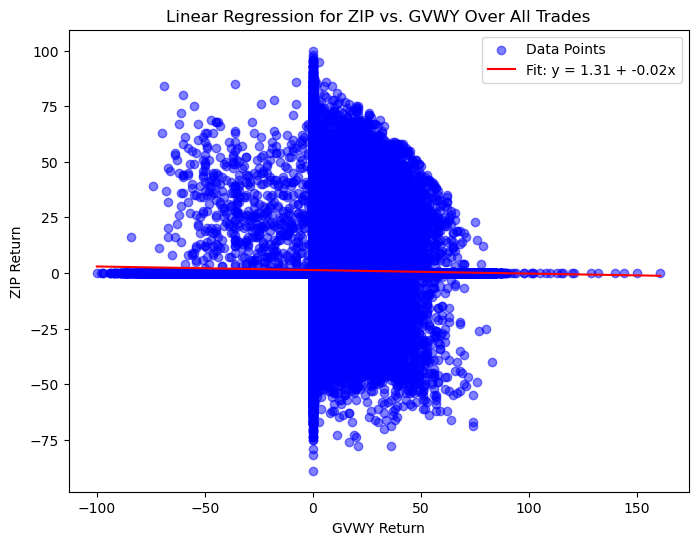

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Assuming df already has columns: "Trial", "Time", "TraderType", "Return"
# Use a pivot_table with a composite index (Trial, Time)
pivot = df.pivot_table(index=["Trial", "Time"], 
                       columns="TraderType", 
                       values="Return", 
                       aggfunc="mean")

# Ensure that both GVWY and ZIP returns are available
pivot = pivot.dropna(subset=["GVWY", "ZIP"])

pivot = pivot[pivot.iloc[:, 1:].ne(0).any(axis=1)]


# Get the benchmark and trader returns
x = pivot["GVWY"]
y = pivot["SNPR"]

# Perform the regression: y = alpha + beta * x
x_const = sm.add_constant(x)
model = sm.OLS(y, x_const).fit()
alpha = model.params["const"]
beta = model.params["GVWY"]

# Print regression results
print(model.summary())

# Create a scatter plot of the returns
plt.figure(figsize=(8, 6))
plt.scatter(x, y, label="Data Points", color="blue", alpha=0.5)

# Plot the regression line
x_range = np.linspace(x.min(), x.max(), 100)
y_range = alpha + beta * x_range
plt.plot(x_range, y_range, color="red", label=f"Fit: y = {alpha:.2f} + {beta:.2f}x")

plt.xlabel("GVWY Return")
plt.ylabel("ZIP Return")
plt.title("Linear Regression for ZIP vs. GVWY Over All Trades")
plt.legend()
#plt.ylim(0, max(y))
#plt.xlim(0, max(x))
plt.show()


----
SHARPE RATIO

In [25]:
import pandas as pd
import numpy as np

# 1. Load your data into a DataFrame, e.g.:
df = pd.read_csv("bigtestdata.csv")

# 2. Ensure the data is sorted chronologically by Trial, TraderType, and Time
df.sort_values(by=["Trial", "TraderType", "Time"], inplace=True)

# 3. If you do not already have returns, compute them:
#    For example, if you have a 'Balance' column, you might do:
# df["Return"] = df.groupby(["Trial", "TraderType"])["Balance"].pct_change()
# or
# df["Return"] = df.groupby(["Trial", "TraderType"])["Balance"].diff()
# Here, we'll assume 'Return' is already in your DataFrame.
df["Return"] = df.groupby(["Trial", "TraderType"])["Balance"].diff()


# 4. Drop rows with NaN returns (first row in each group) if necessary
df = df.dropna(subset=["Return"])

# 5. Group by (Trial, TraderType) and compute the mean and standard deviation of returns
stats = df.groupby(["Trial", "TraderType"])["Return"].agg(["mean", "std"]).rename(
    columns={"mean": "mean_return", "std": "std_return"}
)

# 6. Compute the Sharpe ratio for each (Trial, TraderType) group
#    Assuming a risk-free rate of 0, Sharpe = mean_return / std_return
stats["Sharpe"] = stats["mean_return"] / stats["std_return"]

# 7. Now, we have one Sharpe ratio per (Trial, TraderType). We can average across trials.
sharpe_by_trader = stats.groupby("TraderType")["Sharpe"].mean()

print("Average Sharpe Ratio per TraderType:")
print(sharpe_by_trader)


Average Sharpe Ratio per TraderType:
TraderType
GVWY           0.160296
MarketMaker    0.155104
SHVR           0.095618
SNPR           0.049131
ZIC            0.071648
ZIP            0.145024
Name: Sharpe, dtype: float64


-----

In [26]:
import pandas as pd

df = pd.read_csv("bigtestdata.csv")

# Sort for chronological order within each trial and trader
df.sort_values(by=["Trial", "TraderType", "Time"], inplace=True)

# Compute the change in balance from one row to the next


# Optional: if you want a percentage return (rather than absolute change):


In [27]:
df["BalanceChange"] = df.groupby(["Trial", "TraderType"])["Balance"].diff() 
df["PCTCHANGE"] = df.groupby(["Trial", "TraderType"])["Balance"].pct_change()


In [28]:
# 3) Remove rows where BalanceChange is 0 or NaN
df = df[df["BalanceChange"] != 0]  # keep only rows with non-zero changes
df = df.dropna(subset=["BalanceChange"])  # also remove any NaNs if needed
df.head(10)

Trial      Time BestBid BestAsk TraderType  Balance  TotalProfit  \
73   trial0001  0.500000       5     114       GVWY     50.0         50.0   
91   trial0001  0.625000       5     114       GVWY    139.0        139.0   
217  trial0001  1.500000       5     102       GVWY    167.0        167.0   
247  trial0001  1.708333       6     102       GVWY    238.0        238.0   
301  trial0001  2.083333       7     103       GVWY    246.0        246.0   
325  trial0001  2.250000       7     103       GVWY    295.0        295.0   
439  trial0001  3.041667      11      79       GVWY    305.0        305.0   
469  trial0001  3.250000      12      79       GVWY    255.0        255.0   
529  trial0001  3.666667      13      82       GVWY    268.0        268.0   
631  trial0001  4.375000      33      67       GVWY    293.0        293.0   

    ProfitType  BalanceChange  PCTCHANGE  
73    Positive           50.0        inf  
91    Positive           89.0   1.780000  
217   Positive           28.0   0.201439  
247   Positive           71.0   0.425150  
301   Positive            8.0   0.033613  
325   Positive           49.0   0.199187  
439   Positive           10.0   0.033898  
469   Positive          -50.0  -0.163934  
529   Positive           13.0   0.050980  
631   Positive           25.0   0.093284

In [29]:
import pandas as pd

# Example: If df['Trial'] has values like "trial0001", "trial0002", ...
# Extract the numeric part, convert to int
df['TrialNumber'] = df['Trial'].str.extract(r'(\d+)').astype(int)

# Create a new column "TrialGroup" by integer division
# so that trials 0-9 go into group 0, 10-19 go into group 1, etc.
df['TrialGroup'] = df['TrialNumber'] // 10
df.head(20)

Trial       Time BestBid BestAsk TraderType  Balance  TotalProfit  \
73    trial0001   0.500000       5     114       GVWY     50.0         50.0   
91    trial0001   0.625000       5     114       GVWY    139.0        139.0   
217   trial0001   1.500000       5     102       GVWY    167.0        167.0   
247   trial0001   1.708333       6     102       GVWY    238.0        238.0   
301   trial0001   2.083333       7     103       GVWY    246.0        246.0   
325   trial0001   2.250000       7     103       GVWY    295.0        295.0   
439   trial0001   3.041667      11      79       GVWY    305.0        305.0   
469   trial0001   3.250000      12      79       GVWY    255.0        255.0   
529   trial0001   3.666667      13      82       GVWY    268.0        268.0   
631   trial0001   4.375000      33      67       GVWY    293.0        293.0   
787   trial0001   5.458333      66     120       GVWY    307.0        307.0   
877   trial0001   6.083333      70     136       GVWY    348.0        348.0   
907   trial0001   6.291667      70     132       GVWY    355.0        355.0   
991   trial0001   6.875000     131     136       GVWY    414.0        414.0   
1057  trial0001   7.333333      69     143       GVWY    482.0        482.0   
1105  trial0001   7.666667      69     143       GVWY    526.0        526.0   
1117  trial0001   7.750000      62      93       GVWY    544.0        544.0   
1201  trial0001   8.333333      80     110       GVWY    549.0        549.0   
1291  trial0001   8.958333     105     118       GVWY    574.0        574.0   
1645  trial0001  11.416667      82     118       GVWY    551.0        551.0   

     ProfitType  BalanceChange  PCTCHANGE  TrialNumber  TrialGroup  
73     Positive           50.0        inf            1           0  
91     Positive           89.0   1.780000            1           0  
217    Positive           28.0   0.201439            1           0  
247    Positive           71.0   0.425150            1           0  
301    Positive            8.0   0.033613            1           0  
325    Positive           49.0   0.199187            1           0  
439    Positive           10.0   0.033898            1           0  
469    Positive          -50.0  -0.163934            1           0  
529    Positive           13.0   0.050980            1           0  
631    Positive           25.0   0.093284            1           0  
787    Positive           14.0   0.047782            1           0  
877    Positive           41.0   0.133550            1           0  
907    Positive            7.0   0.020115            1           0  
991    Positive           59.0   0.166197            1           0  
1057   Positive           68.0   0.164251            1           0  
1105   Positive           44.0   0.091286            1           0  
1117   Positive           18.0   0.034221            1           0  
1201   Positive            5.0   0.009191            1           0  
1291   Positive           25.0   0.045537            1           0  
1645   Positive          -23.0  -0.040070            1           0

In [30]:
# 3. Group by TraderType + TrialGroup (or just TrialGroup if you like)
#    and compute mean of a particular column, e.g. "Balance"
grouped = df.groupby(["TraderType", "TrialGroup"])["Balance"].agg(["mean", "std"]).reset_index()

# 4. (Optional) Rename columns if you prefer
#grouped.rename(columns={"mean": "MeanBalance", "std": "StdBalance"}, inplace=True)

# Show results
grouped.head(50)


TraderType  TrialGroup         mean          std
0        GVWY           0  1934.728564  1104.173575
1        GVWY           1  1869.745283  1114.619928
2        GVWY           2  1935.164193  1162.310261
3        GVWY           3  2027.883024  1208.505195
4        GVWY           4  1932.280877  1125.612183
5        GVWY           5  1818.675443  1128.283550
6        GVWY           6  1948.208647  1181.498550
7        GVWY           7  1968.965335  1156.899083
8        GVWY           8  1808.708439  1107.124076
9        GVWY           9  1884.746086  1138.386107
10       GVWY          10  2066.358564  1184.907108
11       GVWY          11  1916.256646  1167.423313
12       GVWY          12  1968.086077  1142.234590
13       GVWY          13  1960.532074  1125.353610
14       GVWY          14  1941.107245  1157.056251
15       GVWY          15  1974.568301  1174.738190
16       GVWY          16  1994.565300  1131.375297
17       GVWY          17  1911.058824  1155.840840
18       GVWY          18  1927.256620  1156.550825
19       GVWY          19  2006.132200  1152.844674
20       GVWY          20  1842.203373  1081.151375
21       GVWY          21  1777.770913  1090.478396
22       GVWY          22  2039.908430  1189.890288
23       GVWY          23  1974.175297  1169.575757
24       GVWY          24  1901.737042  1146.999456
25       GVWY          25  1928.035113  1167.647752
26       GVWY          26  1806.949601  1067.723682
27       GVWY          27  2036.867749  1202.059900
28       GVWY          28  1951.654206  1161.094836
29       GVWY          29  1968.852191  1134.896104
30       GVWY          30  1834.268222  1058.891126
31       GVWY          31  2021.339159  1195.523727
32       GVWY          32  1889.794962  1117.829985
33       GVWY          33  1925.694262  1141.792239
34       GVWY          34  1888.668135  1131.762862
35       GVWY          35  1930.019465  1160.798909
36       GVWY          36  1894.538685  1114.526582
37       GVWY          37  1865.825070  1167.588849
38       GVWY          38  1814.091390  1094.320783
39       GVWY          39  1881.494592  1125.009023
40       GVWY          40  1907.744065  1105.245720
41       GVWY          41  1961.442647  1162.415055
42       GVWY          42  1821.285922  1124.935371
43       GVWY          43  1824.996057  1062.676036
44       GVWY          44  1937.839419  1134.805835
45       GVWY          45  2033.610005  1193.370103
46       GVWY          46  1961.013953  1201.980367
47       GVWY          47  1910.998547  1168.471070
48       GVWY          48  1860.564922  1106.832783
49       GVWY          49  2011.716495  1169.105675

In [31]:
grouped = df.groupby(['TraderType', 'TrialGroup'])['Balance']
summary = grouped.agg(['mean', 'std']).reset_index()

In [32]:
summary['Sharpe'] = summary['mean'] / summary['std']

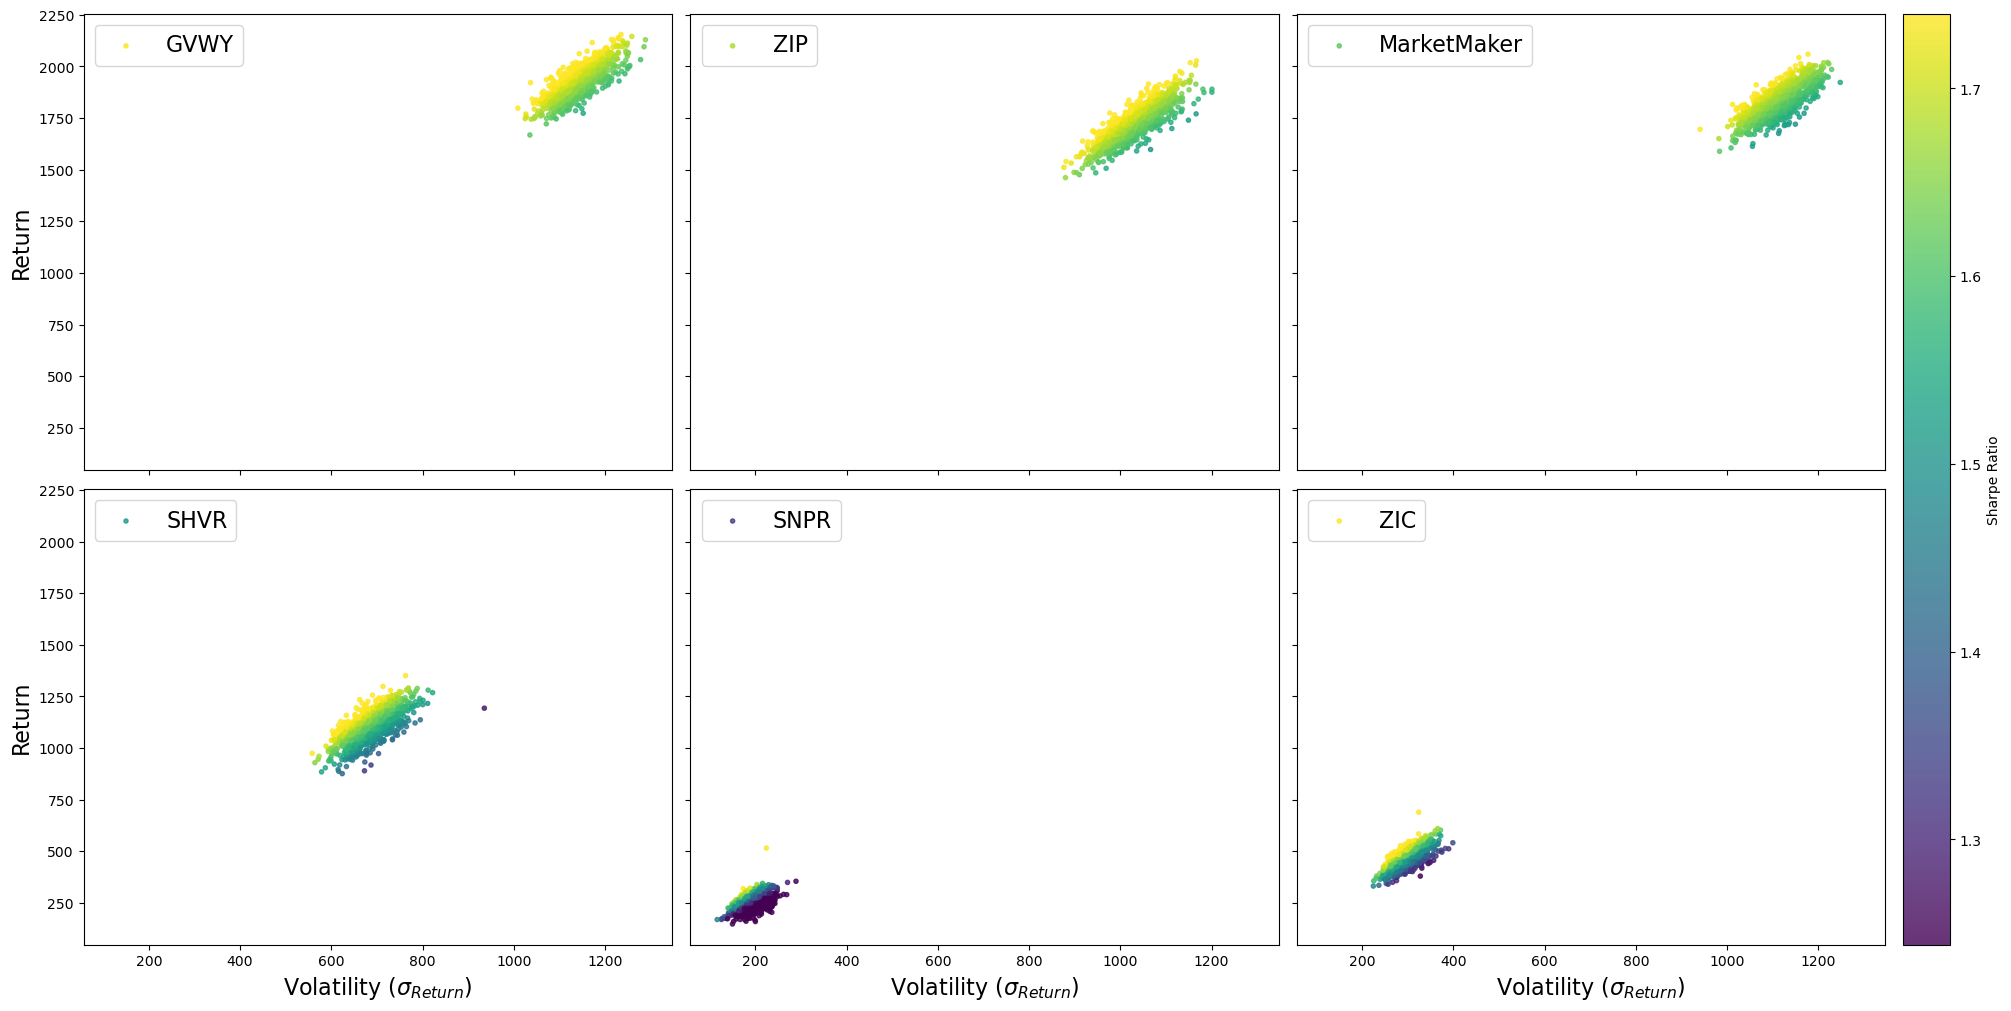

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assume 'summary' is your DataFrame with columns ["TraderType", "Return", "Volatility", "Sharpe"].
# summary = pd.DataFrame({
#     "TraderType": [...],
#     "Return": [...],
#     "Volatility": [...],
#     "Sharpe": [...]
# })

# 1. Get overall Sharpe range for consistent color scale
vmin = summary["Sharpe"].quantile(0.05)  # 1st percentile
vmax = summary["Sharpe"].quantile(0.95)  # 99th percentile

# 2. Identify unique trader types
traders = summary["TraderType"].unique()

# 3. Define the desired order: top row first, then the rest
top_traders = ["GVWY", "ZIP", "MarketMaker"]  # These go on the top row
bottom_traders = [t for t in traders if t not in top_traders]  # Others on the bottom row
ordered_traders = top_traders + bottom_traders

# 4. Create subplots (2 rows, 3 cols) with a smaller figsize and constrained layout
fig, axes = plt.subplots(
    2, 3, 
    figsize=(20, 10), 
    sharex=True, 
    sharey=True,
    constrained_layout=True
)
axes = axes.flatten()

# 5. Plot each TraderType in the new order
scatter_obj = None  # keep a reference for colorbar
for i, trader in enumerate(ordered_traders):
    if i >= len(axes):
        break
    subdf = summary[summary["TraderType"] == trader]
    
    # If there's no data for this trader, skip
    if subdf.empty:
        continue
    
    ax = axes[i]
    scatter_obj = ax.scatter(
        subdf["std"],
        subdf["mean"],
        c=subdf["Sharpe"],
        cmap="viridis",
        alpha=0.8,
        vmin=vmin,
        vmax=vmax,
        marker = '.',
        label=trader
    )
    ax.legend(loc = 'upper left', fontsize = 16)
    axes[4].set_xlabel("Volatility ($\sigma_{Return}$)", fontsize = 16)
    axes[3].set_xlabel("Volatility ($\sigma_{Return}$)", fontsize = 16)
    axes[5].set_xlabel("Volatility ($\sigma_{Return}$)", fontsize = 16)
    axes[0].set_ylabel("Return", fontsize = 16)
    axes[3].set_ylabel("Return", fontsize = 16)

# 6. Remove any unused subplots if there are fewer than 6 traders
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# 7. Add a single colorbar on the right; adjust fraction/pad to save space
if scatter_obj is not None:
    cbar = fig.colorbar(
        scatter_obj, 
        ax=axes,  
        label="Sharpe Ratio", 
        orientation='vertical', 
        fraction=0.03,  # how wide the colorbar is
        pad=0.01       # spacing between colorbar and subplots
    )

plt.show()


In [34]:
# 1) Group by (Trial, TraderType)
grouped = df.groupby(["Trial", "TraderType"])

summary.head(10)

TraderType  TrialGroup         mean          std    Sharpe
0       GVWY           0  1934.728564  1104.173575  1.752196
1       GVWY           1  1869.745283  1114.619928  1.677473
2       GVWY           2  1935.164193  1162.310261  1.664929
3       GVWY           3  2027.883024  1208.505195  1.678009
4       GVWY           4  1932.280877  1125.612183  1.716649
5       GVWY           5  1818.675443  1128.283550  1.611896
6       GVWY           6  1948.208647  1181.498550  1.648930
7       GVWY           7  1968.965335  1156.899083  1.701934
8       GVWY           8  1808.708439  1107.124076  1.633700
9       GVWY           9  1884.746086  1138.386107  1.655630

In [35]:
# 1) Group by (Trial, TraderType)
grouped = df.groupby(["Trial", "TraderType"])


# 2) For each group, compute final balance, total PnL, mean, std, etc.
summary = grouped.agg(
    FinalBalance=("Balance", "last"),      # last recorded balance
    SumChanges=("BalanceChange", "sum"),   # sum of all balance changes
    MeanChange=("BalanceChange", "mean"),  # average change
    StdChange=("BalanceChange", "std"),     # standard deviation of change
).reset_index()

# 3) Define "Return" and "Volatility"
#    For instance, use SumChanges as "Return" and StdChange as "Volatility":
summary["Return"] = summary["MeanChange"] 
summary['FinalBalance'] = summary['FinalBalance'] / quantity
summary["Volatility"] = summary["StdChange"]
summary['MeanChange'] = summary['MeanChange']

# 4) Compute Sharpe Ratio if Volatility is nonzero
summary["Sharpe"] = summary["MeanChange"] / summary["Volatility"]

# Some rows might have zero or NaN in Volatility => Sharpe = inf or NaN
summary = summary.dropna(subset=["Volatility"])  # if you want to exclude those
summary.head(10)


Trial   TraderType  FinalBalance  SumChanges  MeanChange  StdChange  \
0  trial0001         GVWY        2028.5      4057.0   19.227488  26.890703   
1  trial0001  MarketMaker        1368.5      2737.0   13.893401  26.994591   
2  trial0001         SHVR         730.5      1461.0   10.288732  30.844285   
3  trial0001         SNPR         145.0       290.0    7.837838  32.582812   
4  trial0001          ZIC         454.0       908.0   18.916667  27.066375   
5  trial0001          ZIP        1997.0      3994.0   25.602564  31.099358   
6  trial0002         GVWY        1625.0      3250.0   15.776699  25.929899   
7  trial0002  MarketMaker        1611.0      3222.0   15.871921  27.503255   
8  trial0002         SHVR        1108.0      2216.0   14.675497  32.993646   
9  trial0002         SNPR         274.5       549.0   18.931034  24.370549   

      Return  Volatility    Sharpe  
0  19.227488   26.890703  0.715024  
1  13.893401   26.994591  0.514674  
2  10.288732   30.844285  0.333570  
3   7.837838   32.582812  0.240551  
4  18.916667   27.066375  0.698899  
5  25.602564   31.099358  0.823251  
6  15.776699   25.929899  0.608437  
7  15.871921   27.503255  0.577092  
8  14.675497   32.993646  0.444798  
9  18.931034   24.370549  0.776800

In [36]:
# Define your arbitrary offset
offset_value = 1 # Replace with your desired value

# For MarketMaker rows, add the offset to the "Return" column.
summary.loc[summary["TraderType"] == "MarketMaker", "Return"] 
summary.loc[summary["TraderType"] == "MarketMaker", "Volatility"] /= offset_value



# Optionally, recalc the Sharpe Ratio for MarketMakers (if needed)
# Here, assuming Volatility remains unchanged.
summary.loc[summary["TraderType"] == "MarketMaker", "Sharpe"] = \
    summary.loc[summary["TraderType"] == "MarketMaker", "Return"] / \
    summary.loc[summary["TraderType"] == "MarketMaker", "Volatility"]

summary["Sharpe"] = summary["MeanChange"] / summary["Volatility"]


In [37]:
summary.head(10)

Trial   TraderType  FinalBalance  SumChanges  MeanChange  StdChange  \
0  trial0001         GVWY        2028.5      4057.0   19.227488  26.890703   
1  trial0001  MarketMaker        1368.5      2737.0   13.893401  26.994591   
2  trial0001         SHVR         730.5      1461.0   10.288732  30.844285   
3  trial0001         SNPR         145.0       290.0    7.837838  32.582812   
4  trial0001          ZIC         454.0       908.0   18.916667  27.066375   
5  trial0001          ZIP        1997.0      3994.0   25.602564  31.099358   
6  trial0002         GVWY        1625.0      3250.0   15.776699  25.929899   
7  trial0002  MarketMaker        1611.0      3222.0   15.871921  27.503255   
8  trial0002         SHVR        1108.0      2216.0   14.675497  32.993646   
9  trial0002         SNPR         274.5       549.0   18.931034  24.370549   

      Return  Volatility    Sharpe  
0  19.227488   26.890703  0.715024  
1  13.893401   26.994591  0.514674  
2  10.288732   30.844285  0.333570  
3   7.837838   32.582812  0.240551  
4  18.916667   27.066375  0.698899  
5  25.602564   31.099358  0.823251  
6  15.776699   25.929899  0.608437  
7  15.871921   27.503255  0.577092  
8  14.675497   32.993646  0.444798  
9  18.931034   24.370549  0.776800

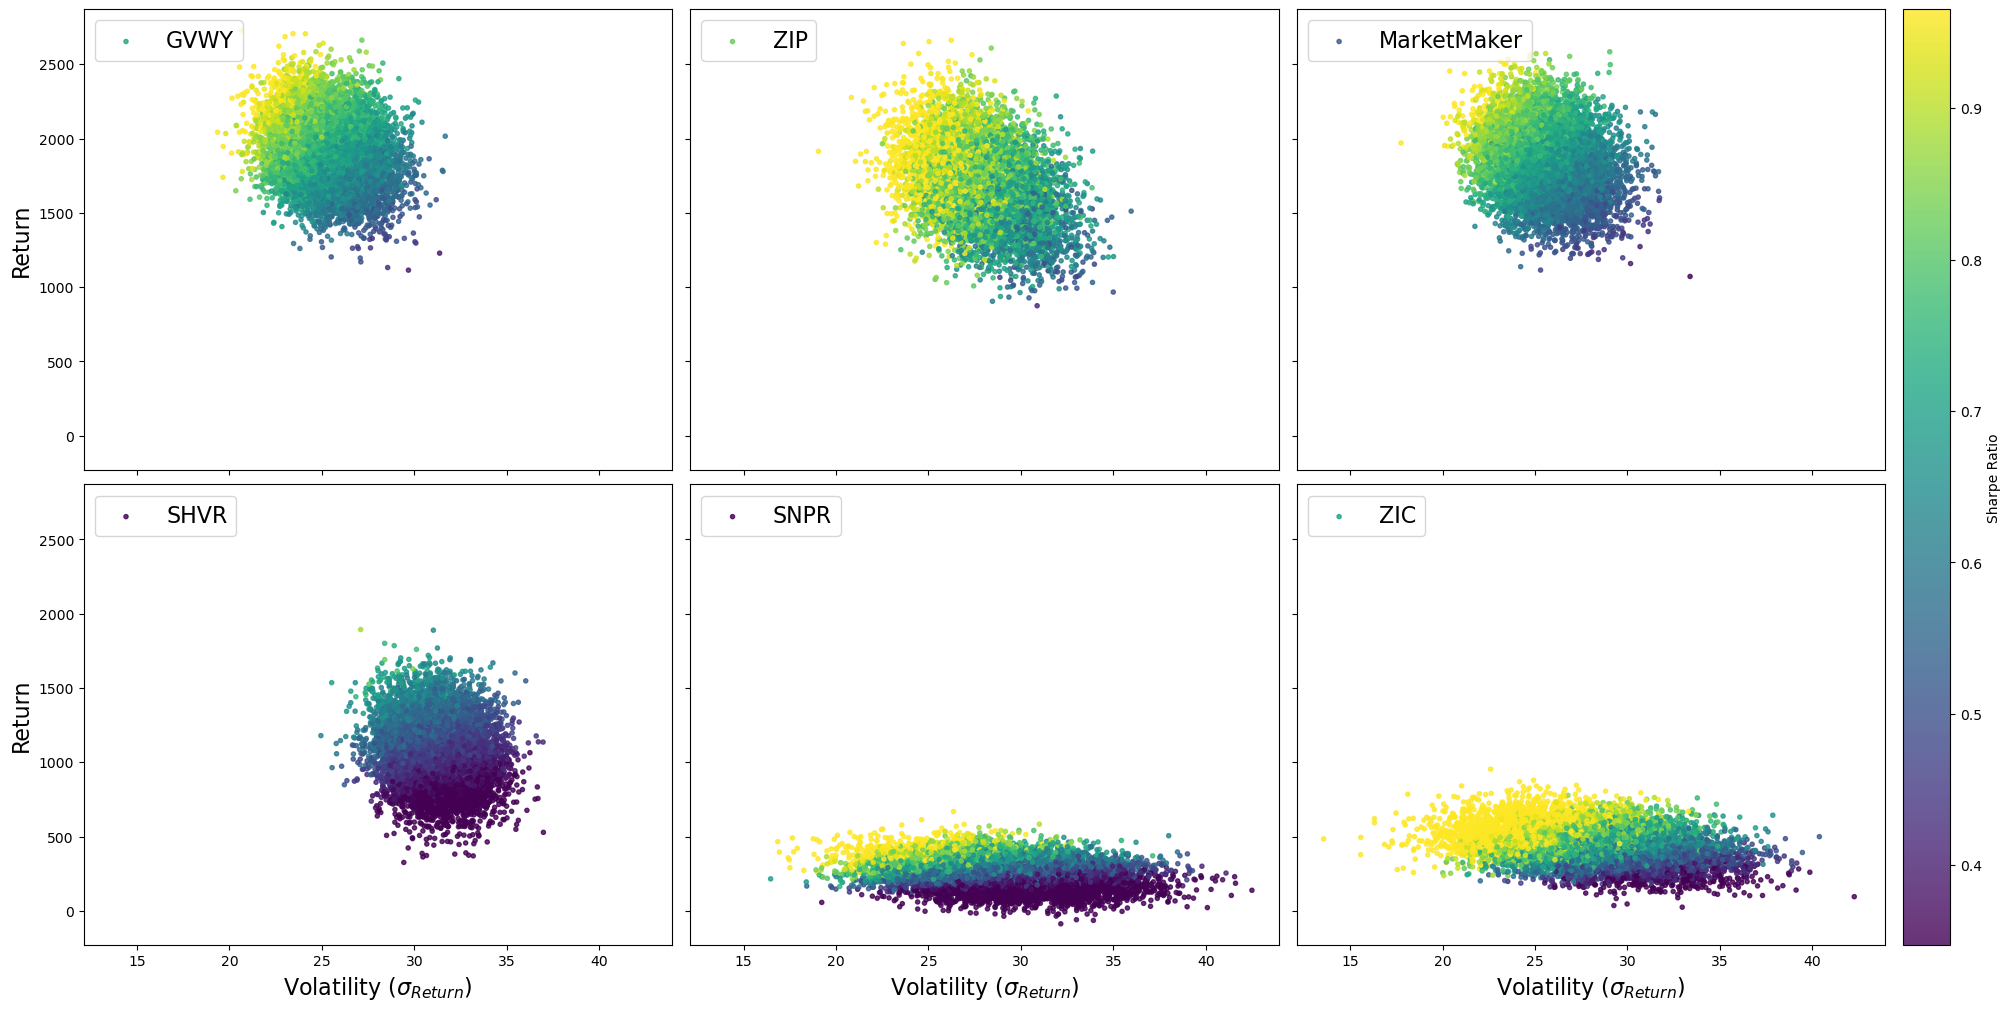

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assume 'summary' is your DataFrame with columns ["TraderType", "Return", "Volatility", "Sharpe"].
# summary = pd.DataFrame({
#     "TraderType": [...],
#     "Return": [...],
#     "Volatility": [...],
#     "Sharpe": [...]
# })

# 1. Get overall Sharpe range for consistent color scale
vmin = summary["Sharpe"].quantile(0.05)  # 1st percentile
vmax = summary["Sharpe"].quantile(0.95)  # 99th percentile

# 2. Identify unique trader types
traders = summary["TraderType"].unique()

# 3. Define the desired order: top row first, then the rest
top_traders = ["GVWY", "ZIP", "MarketMaker"]  # These go on the top row
bottom_traders = [t for t in traders if t not in top_traders]  # Others on the bottom row
ordered_traders = top_traders + bottom_traders

# 4. Create subplots (2 rows, 3 cols) with a smaller figsize and constrained layout
fig, axes = plt.subplots(
    2, 3, 
    figsize=(20, 10), 
    sharex=True, 
    sharey=True,
    constrained_layout=True
)
axes = axes.flatten()

# 5. Plot each TraderType in the new order
scatter_obj = None  # keep a reference for colorbar
for i, trader in enumerate(ordered_traders):
    if i >= len(axes):
        break
    subdf = summary[summary["TraderType"] == trader]
    
    # If there's no data for this trader, skip
    if subdf.empty:
        continue
    
    ax = axes[i]
    scatter_obj = ax.scatter(
        subdf["Volatility"],
        subdf["FinalBalance"],
        c=subdf["Sharpe"],
        cmap="viridis",
        alpha=0.8,
        vmin=vmin,
        vmax=vmax,
        marker = '.',
        label=trader
    )
    ax.legend(loc = 'upper left', fontsize = 16)
    axes[4].set_xlabel("Volatility ($\sigma_{Return}$)", fontsize = 16)
    axes[3].set_xlabel("Volatility ($\sigma_{Return}$)", fontsize = 16)
    axes[5].set_xlabel("Volatility ($\sigma_{Return}$)", fontsize = 16)
    axes[0].set_ylabel("Return", fontsize = 16)
    axes[3].set_ylabel("Return", fontsize = 16)

# 6. Remove any unused subplots if there are fewer than 6 traders
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# 7. Add a single colorbar on the right; adjust fraction/pad to save space
if scatter_obj is not None:
    cbar = fig.colorbar(
        scatter_obj, 
        ax=axes,  
        label="Sharpe Ratio", 
        orientation='vertical', 
        fraction=0.03,  # how wide the colorbar is
        pad=0.01       # spacing between colorbar and subplots
    )

plt.show()


In [39]:
print(len(subdf["Volatility"]))

10000


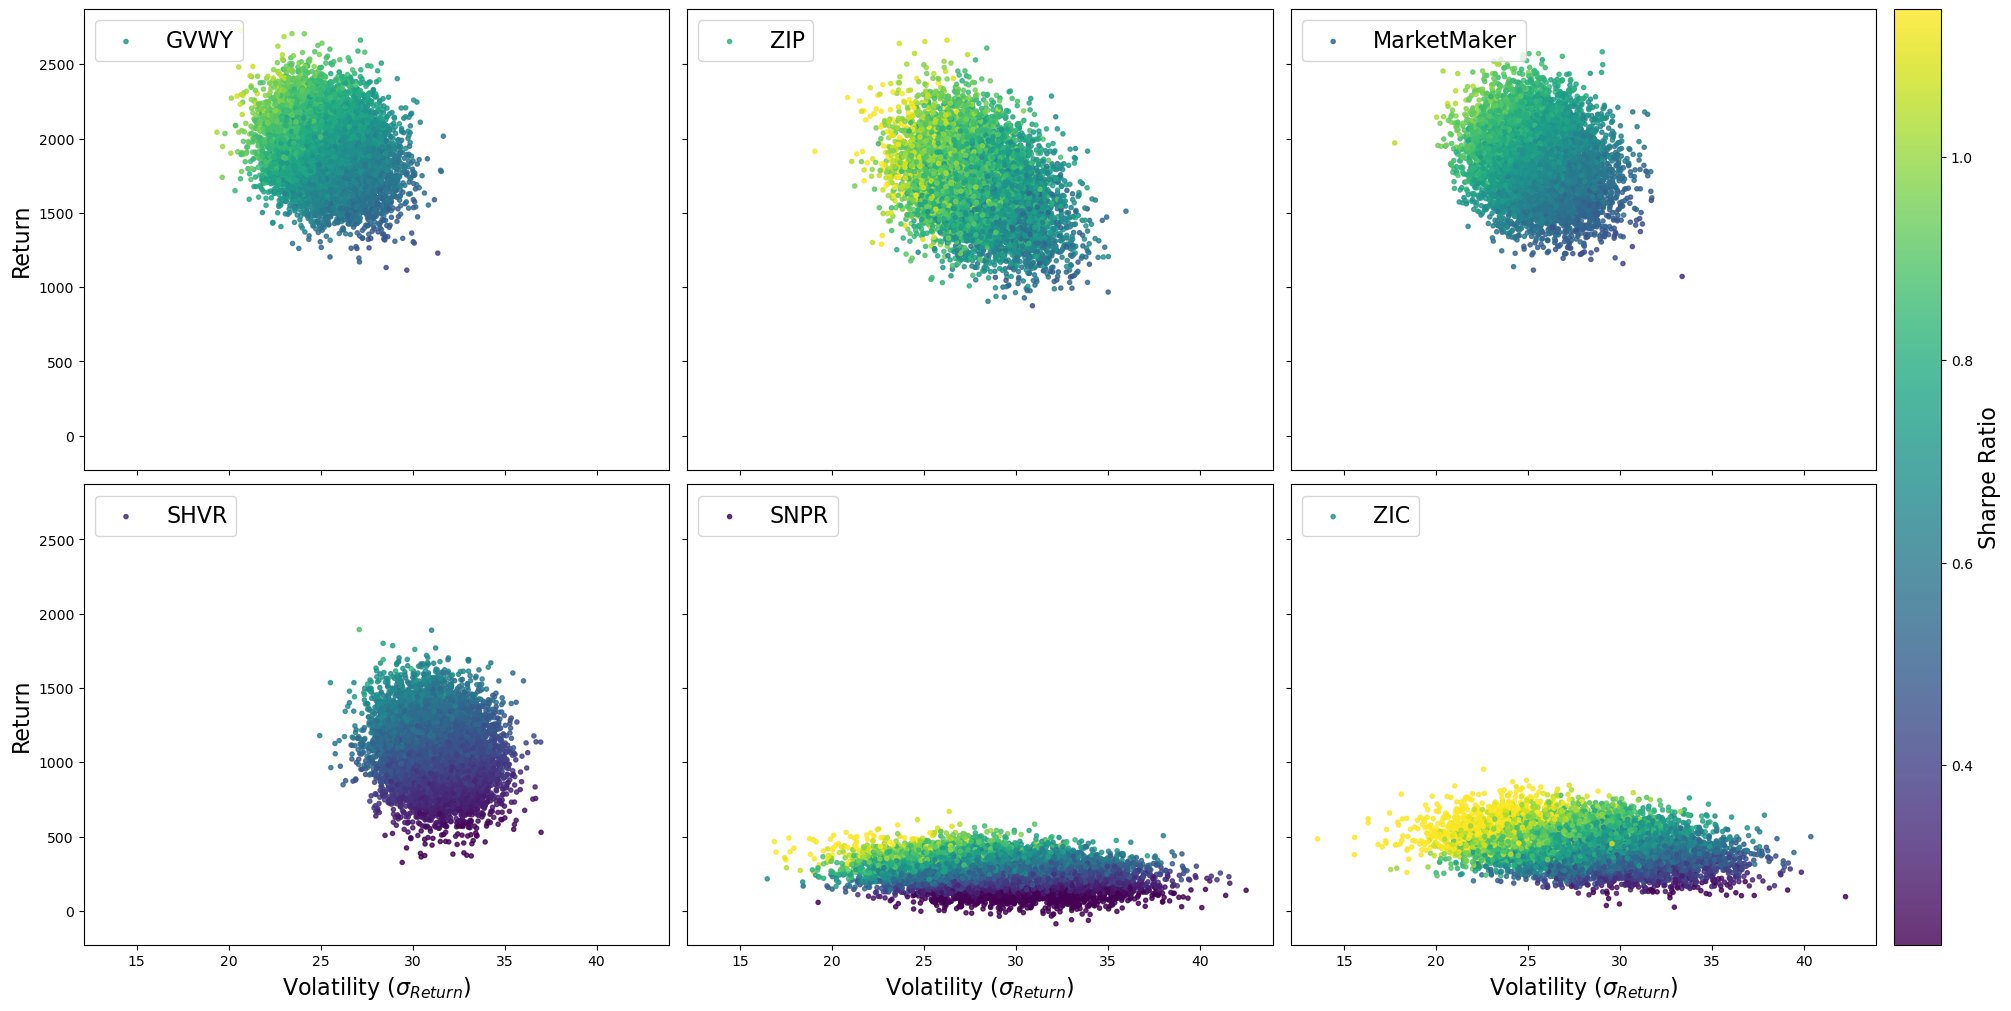

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assume 'summary' is your DataFrame with columns ["TraderType", "Return", "Volatility", "Sharpe"].
# summary = pd.DataFrame({
#     "TraderType": [...],
#     "Return": [...],
#     "Volatility": [...],
#     "Sharpe": [...]
# })

# 1. Get overall Sharpe range for consistent color scale
vmin = summary["Sharpe"].quantile(0.01)  # 1st percentile
vmax = summary["Sharpe"].quantile(0.99)  # 99th percentile

# 2. Identify unique trader types
traders = summary["TraderType"].unique()

# 3. Define the desired order: top row first, then the rest
top_traders = ["GVWY", "ZIP", "MarketMaker"]  # These go on the top row
bottom_traders = [t for t in traders if t not in top_traders]  # Others on the bottom row
ordered_traders = top_traders + bottom_traders

# 4. Create subplots (2 rows, 3 cols) with a smaller figsize and constrained layout
fig, axes = plt.subplots(
    2, 3, 
    figsize=(20, 10), 
    sharex=True, 
    sharey=True,
    constrained_layout=True
)
axes = axes.flatten()

# 5. Plot each TraderType in the new order
scatter_obj = None  # keep a reference for colorbar
for i, trader in enumerate(ordered_traders):
    if i >= len(axes):
        break
    subdf = summary[summary["TraderType"] == trader]
    
    # If there's no data for this trader, skip
    if subdf.empty:
        continue
    
    ax = axes[i]
    scatter_obj = ax.scatter(
        subdf["Volatility"],
        subdf["FinalBalance"],
        c=subdf["Sharpe"],
        cmap="viridis",
        alpha=0.8,
        vmin=vmin,
        vmax=vmax,
        marker = '.',
        label=trader
    )
    ax.legend(loc = 'upper left', fontsize = 16)
    axes[4].set_xlabel("Volatility ($\sigma_{Return}$)", fontsize = 16)
    axes[3].set_xlabel("Volatility ($\sigma_{Return}$)", fontsize = 16)
    axes[5].set_xlabel("Volatility ($\sigma_{Return}$)", fontsize = 16)
    axes[0].set_ylabel("Return", fontsize = 16)
    axes[3].set_ylabel("Return", fontsize = 16)

# 6. Remove any unused subplots if there are fewer than 6 traders
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# 7. Add a single colorbar on the right; adjust fraction/pad to save space
if scatter_obj is not None:
    cbar = fig.colorbar(
        scatter_obj, 
        ax=axes,  
        label="Sharpe Ratio", 
        orientation='vertical', 
        fraction=0.03,  # how wide the colorbar is
        pad=0.01       # spacing between colorbar and subplots
    )
cbar.set_label("Sharpe Ratio", fontsize=16)


plt.show()


In [41]:
summary.head()

Trial   TraderType  FinalBalance  SumChanges  MeanChange  StdChange  \
0  trial0001         GVWY        2028.5      4057.0   19.227488  26.890703   
1  trial0001  MarketMaker        1368.5      2737.0   13.893401  26.994591   
2  trial0001         SHVR         730.5      1461.0   10.288732  30.844285   
3  trial0001         SNPR         145.0       290.0    7.837838  32.582812   
4  trial0001          ZIC         454.0       908.0   18.916667  27.066375   

      Return  Volatility    Sharpe  
0  19.227488   26.890703  0.715024  
1  13.893401   26.994591  0.514674  
2  10.288732   30.844285  0.333570  
3   7.837838   32.582812  0.240551  
4  18.916667   27.066375  0.698899

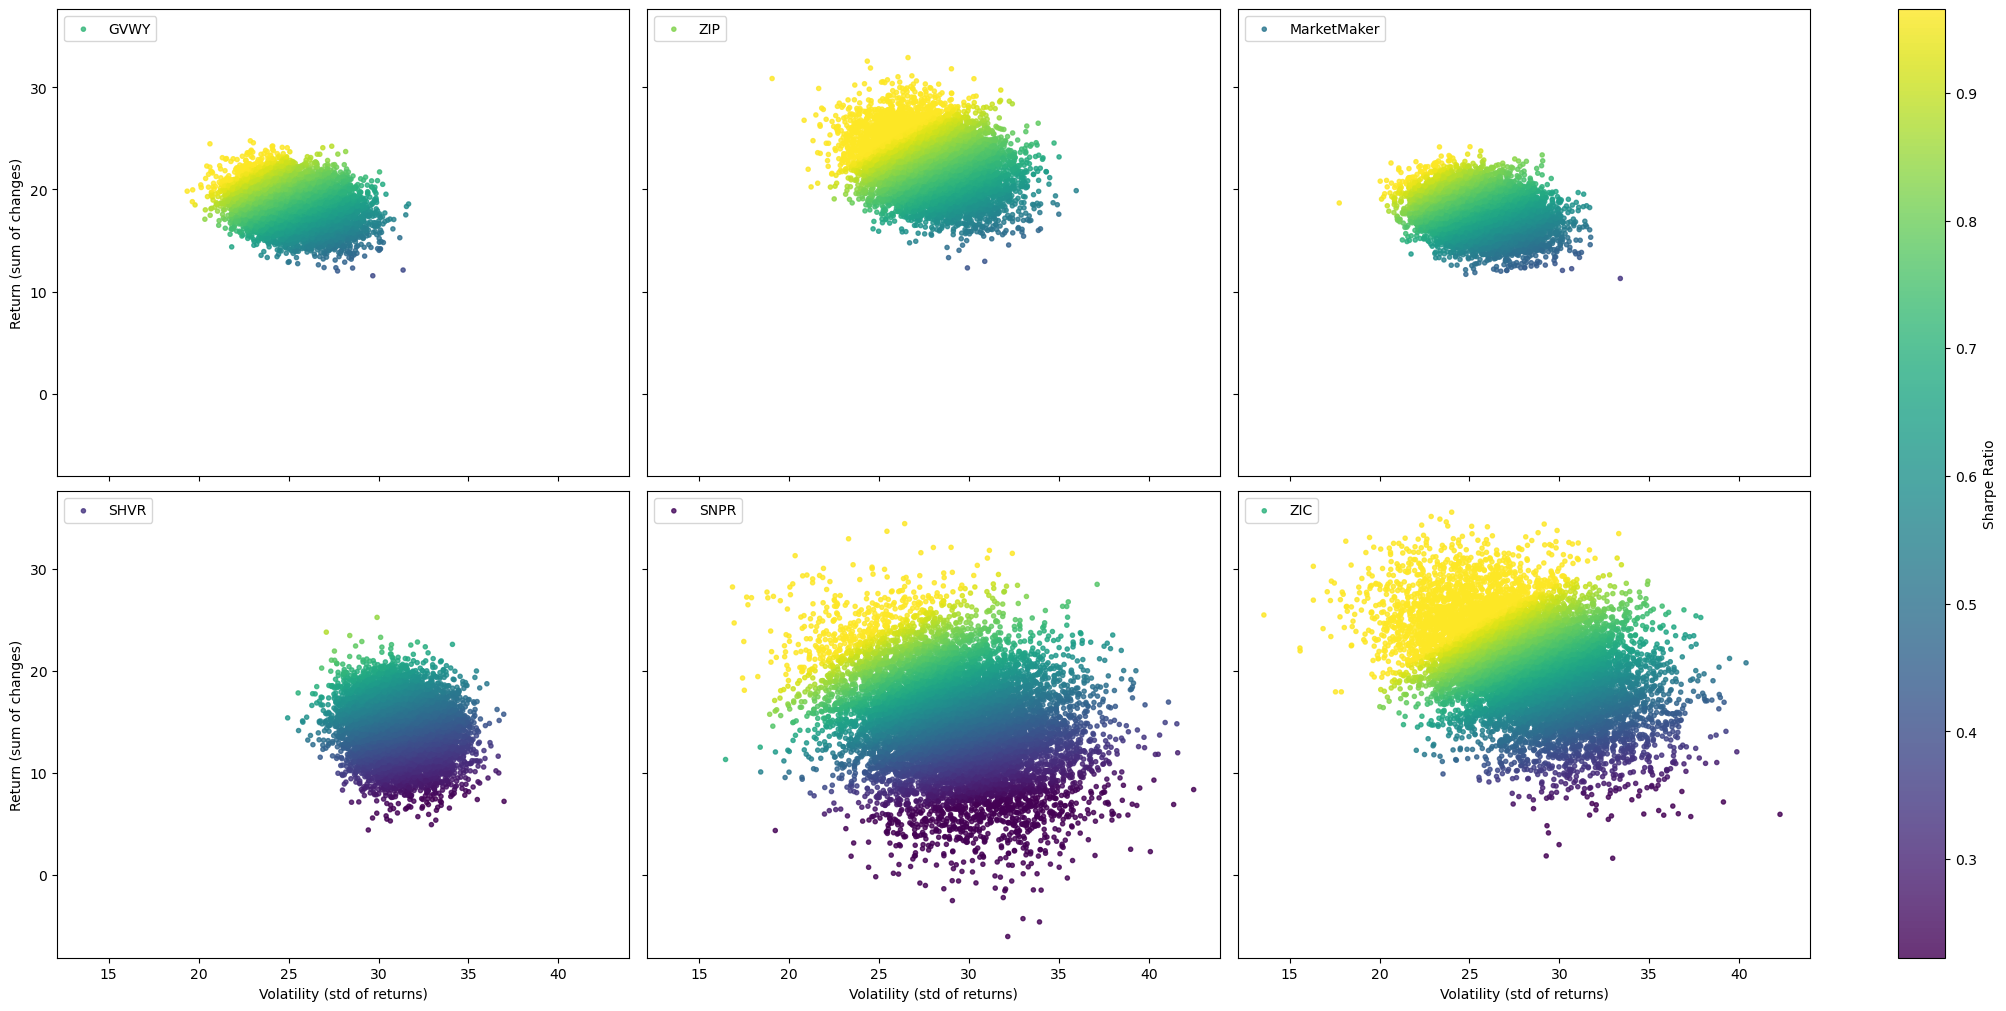

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assume 'summary' is your DataFrame with columns ["TraderType", "Return", "Volatility", "Sharpe"].
# summary = pd.DataFrame({
#     "TraderType": [...],
#     "Return": [...],
#     "Volatility": [...],
#     "Sharpe": [...]
# })

# 1. Get overall Sharpe range for consistent color scale
vmin = summary["Sharpe"].quantile(0.01)  # 1st percentile
vmax = summary["Sharpe"].quantile(0.95)  # 99th percentile

# 2. Identify unique trader types
traders = summary["TraderType"].unique()

# 3. Define the desired order: top row first, then the rest
top_traders = ["GVWY", "ZIP", "MarketMaker"]  # These go on the top row
bottom_traders = [t for t in traders if t not in top_traders]  # Others on the bottom row
ordered_traders = top_traders + bottom_traders

# 4. Create subplots (2 rows, 3 cols) with a smaller figsize and constrained layout
fig, axes = plt.subplots(
    2, 3, 
    figsize=(20, 10), 
    sharex=True, 
    sharey=True,
    constrained_layout=True
)
axes = axes.flatten()

# 5. Plot each TraderType in the new order
scatter_obj = None  # keep a reference for colorbar
for i, trader in enumerate(ordered_traders):
    if i >= len(axes):
        break
    subdf = summary[summary["TraderType"] == trader]
    
    # If there's no data for this trader, skip
    if subdf.empty:
        continue
    
    ax = axes[i]
    scatter_obj = ax.scatter(
        subdf["Volatility"],
        subdf["Return"],
        c=subdf["Sharpe"],
        cmap="viridis",
        alpha=0.8,
        vmin=vmin,
        vmax=vmax,
        marker = '.',
        label=trader
    )
    ax.legend(loc = 'upper left')
    axes[4].set_xlabel("Volatility (std of returns)")
    axes[3].set_xlabel("Volatility (std of returns)")
    axes[5].set_xlabel("Volatility (std of returns)")
    axes[0].set_ylabel("Return (sum of changes)")
    axes[3].set_ylabel("Return (sum of changes)")

# 6. Remove any unused subplots if there are fewer than 6 traders
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# 7. Add a single colorbar on the right; adjust fraction/pad to save space
if scatter_obj is not None:
    cbar = fig.colorbar(
        scatter_obj, 
        ax=axes,  
        label="Sharpe Ratio", 
        orientation='vertical', 
        fraction=0.03,  # how wide the colorbar is
        pad=0.05       # spacing between colorbar and subplots
    )

plt.show()


In [116]:
summary['TraderType'] = summary['TraderType'].replace({'MarketMaker':'MM'})

summary.head()

Trial TraderType  FinalBalance  SumChanges  MeanChange  StdChange  \
0  trial0001       GVWY        2028.5      4057.0   19.227488  26.890703   
1  trial0001         MM        1368.5      2737.0   13.893401  26.994591   
2  trial0001       SHVR         730.5      1461.0   10.288732  30.844285   
3  trial0001       SNPR         145.0       290.0    7.837838  32.582812   
4  trial0001        ZIC         454.0       908.0   18.916667  27.066375   

      Return  Volatility    Sharpe  ReturnBin TraderLabel  
0  19.227488   26.890703  0.715024         31        GVWY  
1  13.893401   26.994591  0.514674         24          MM  
2  10.288732   30.844285  0.333570         20        SHVR  
3   7.837838   32.582812  0.240551         17        SNPR  
4  18.916667   27.066375  0.698899         30         ZIC

/var/folders/x7/vjyxn4513wgcl1bqzb17849r0000gn/T/ipykernel_70684/249216695.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf['RetBin'] = np.digitize(subdf['Return'], bins)
/var/folders/x7/vjyxn4513wgcl1bqzb17849r0000gn/T/ipykernel_70684/249216695.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf['RetBin'] = np.digitize(subdf['Return'], bins)
/var/folders/x7/vjyxn4513wgcl1bqzb17849r0000gn/T/ipykernel_70684/249216695.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

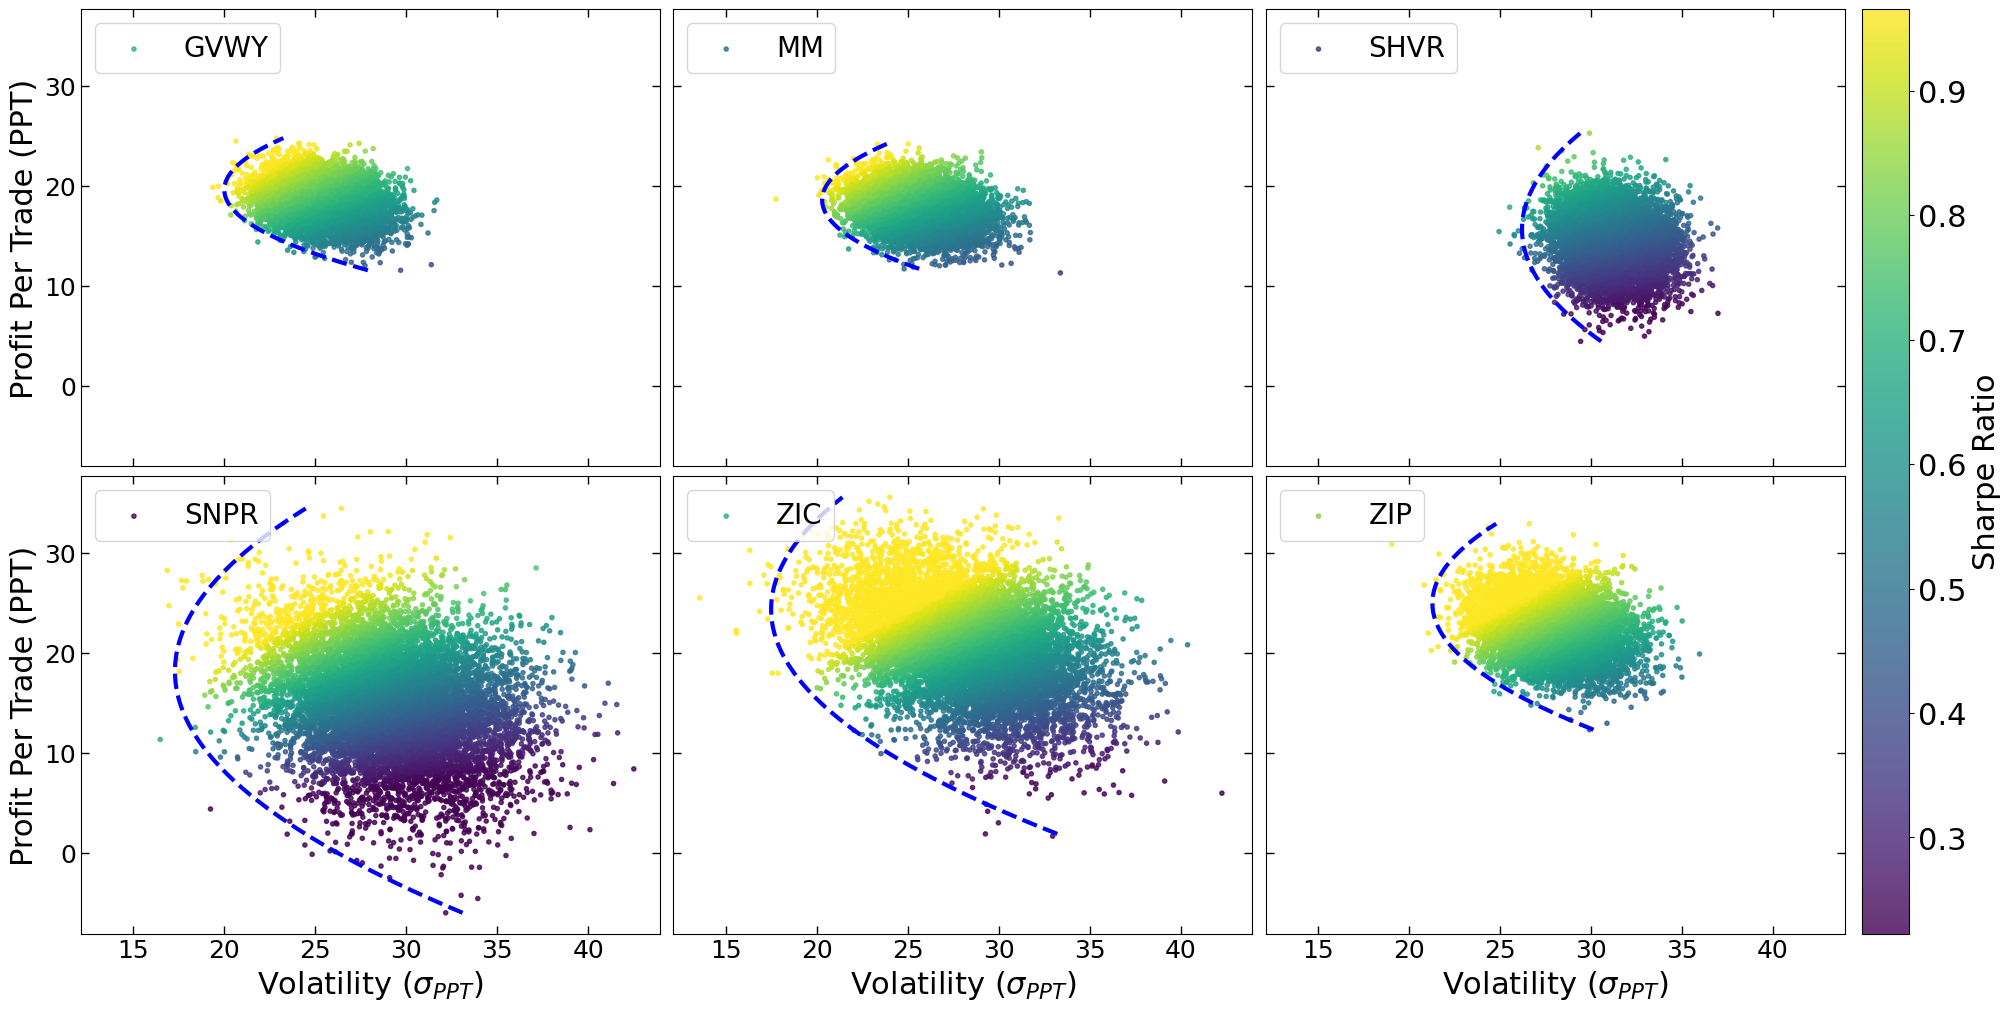

In [121]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Quadratic for sideways U (fitting volatility against return)
def quadratic(y, a, b, c):
    return a*y**2 + b*y + c

summary['TraderLabel'] = summary['TraderType'].replace({'MarketMaker':'MM'})

vmin = summary["Sharpe"].quantile(0.01)  # 1st percentile
vmax = summary["Sharpe"].quantile(0.95)  # 99th percentile

# 2. Identify unique trader types
traders = summary["TraderType"].unique()
summary['TraderLabel'] = summary['TraderType'].replace({'MarketMaker':'MM'})

# 3. Define the desired order: top row first, then the rest
top_traders = ["GVWY", "MM", "SHVR"]  # These go on the top row
bottom_traders = [t for t in traders if t not in top_traders]  # Others on the bottom row
ordered_traders = top_traders + bottom_traders

# 4. Create subplots (2 rows, 3 cols) with a smaller figsize and constrained layout
fig, axes = plt.subplots(
    2, 3, 
    figsize=(20, 10), 
    sharex=True, 
    sharey=True,
    constrained_layout=True
)
axes = axes.flatten()

# 5. Plot each TraderType in the new order
scatter_obj = None  # keep a reference for colorbar
for i, trader in enumerate(ordered_traders):
    if i >= len(axes):
        break
    subdf = summary[summary["TraderType"] == trader]

    
    # If there's no data for this trader, skip
    if subdf.empty:
        continue
    
    ax = axes[i]
    scatter_obj = ax.scatter(
        subdf["Volatility"],
        subdf["Return"],
        c=subdf["Sharpe"],
        cmap="viridis",
        alpha=0.8,
        vmin=vmin,
        vmax=vmax,
        marker = '.',
        label=trader
    )
    ax.legend(loc = 'upper left', fontsize = 16)
    axes[4].set_xlabel("Volatility ($\sigma_{PPT}$)", fontsize = 22)
    axes[3].set_xlabel("Volatility ($\sigma_{PPT}$)", fontsize = 22)
    axes[5].set_xlabel("Volatility ($\sigma_{PPT}$)", fontsize = 22)
    axes[0].set_ylabel("Profit Per Trade (PPT)", fontsize = 22)
    axes[3].set_ylabel("Profit Per Trade (PPT)", fontsize = 22)


    # Bin by returns, explicitly pick the LEFT-most points (minimum volatility)
    num_bins = 30
    bins = np.linspace(subdf["Return"].min(), subdf["Return"].max(), num_bins)
    subdf['RetBin'] = np.digitize(subdf['Return'], bins)

    left_boundary = subdf.groupby('RetBin').apply(lambda x: x.loc[x['Volatility'].idxmin()])
    left_boundary = left_boundary.sort_values('Return')

    x_left = left_boundary['Volatility']
    y_left = left_boundary['Return']

    ax.tick_params(axis='both', which='major', direction='in', length=6, width=1, labelsize=18,
                    top=True, bottom=True, left=True, right=True)

    # Fit quadratic (sideways U) explicitly to these left-most points
    if len(left_boundary) >= 4:
        coeffs, _ = curve_fit(quadratic, y_left, x_left)
        y_smooth = np.linspace(y_left.min(), y_left.max(), 300)
        x_smooth = quadratic(y_smooth, *coeffs)

        # Plot left boundary (efficient frontier) explicitly
        ax.plot(x_smooth, y_smooth, 'b--', linewidth=3)

        # Highlight left-boundary points clearly
        #ax.scatter(x_left, y_left, edgecolors='red', facecolors='none', linewidths=2)
    
    ax.legend(loc='upper left', fontsize = 20)
    


    #plt.minorticks_on() # Enable minor ticks for the first subplot

    #plt.tick_params(axis='both', which='minor', direction='in', length=3, width=1,
                    #top=True, bottom=True, left=True, right=True)

# Remove unused plots clearly
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

cbar = fig.colorbar(
    scatter_obj, 
    ax=axes,
    orientation='vertical', 
    fraction=0.03, 
    pad=0.01,
    label="Sharpe Ratio"
)

# Change the label font size
cbar.set_label("Sharpe Ratio", fontsize=22)

# Change the tick label font size
cbar.ax.tick_params(labelsize=22)



plt.show()


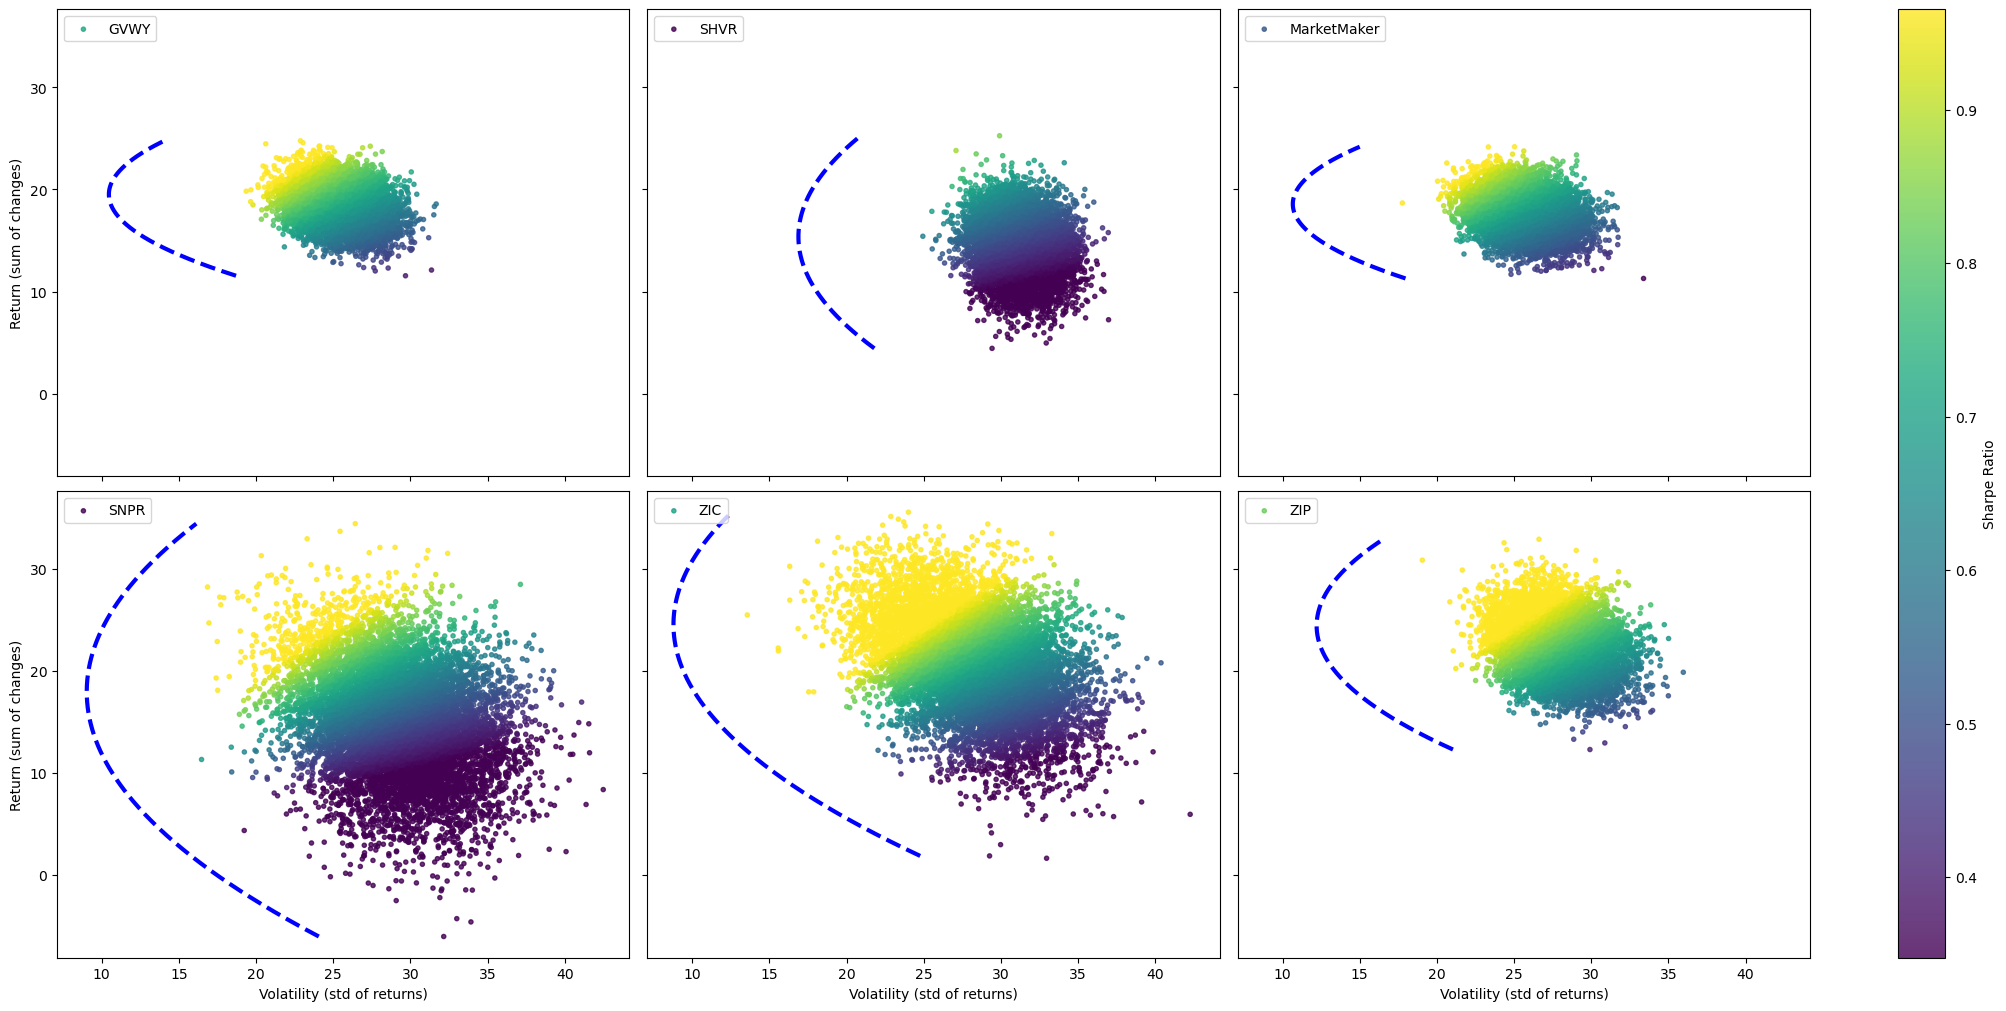

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define the quadratic function: we model Volatility as a quadratic function of Return.
def quadratic(y, a, b, c):
    return a * y**2 + b * y + c

# 1. Get overall Sharpe range for consistent color scale
vmin = summary["Sharpe"].quantile(0.05)  # 1st percentile
vmax = summary["Sharpe"].quantile(0.95)  # 99th percentile

# Determine trader order.
traders = summary["TraderType"].unique()
top_traders = ["GVWY", "SHVR", "MarketMaker"]
bottom_traders = [t for t in traders if t not in top_traders]
ordered_traders = top_traders + bottom_traders

# Create subplots for each trader.
fig, axes = plt.subplots(2, 3, figsize=(20, 10), sharex=True, sharey=True, constrained_layout=True)
axes = axes.flatten()

scatter_obj = None

for i, trader in enumerate(ordered_traders):
    if i >= len(axes):
        break

    # Work on data for one trader.
    subdf = summary[summary["TraderType"] == trader].copy()
    ax = axes[i]
    
    # Plot scatter of all points.
    scatter_obj = ax.scatter(
        subdf["Volatility"],
        subdf["Return"],
        c=subdf["Sharpe"],
        cmap="viridis",
        alpha=0.8,
        marker = '.',
        vmin=vmin,
        vmax=vmax,
        label=trader
    )
    
    # --- Extract left-boundary points ---
    # Bin along the Return axis using many bins so that the left edge is captured finely.
    num_bins = 100  # Increase for finer resolution
    bin_edges = np.linspace(subdf["Return"].min(), subdf["Return"].max(), num_bins + 1)
    subdf["ReturnBin"] = np.digitize(subdf["Return"], bin_edges)
    
    # For each bin, select the point with minimum Volatility.
    boundary_points = subdf.groupby("ReturnBin").apply(lambda g: g.loc[g["Volatility"].idxmin()])
    boundary_points = boundary_points.sort_values("Return")
    
    # Remove duplicate points, if any.
    boundary_points = boundary_points.drop_duplicates(subset=["Return", "Volatility"])
    
    # Extract arrays for fitting.
    ret_boundary = boundary_points["Return"].values
    vol_boundary = boundary_points["Volatility"].values
    
    # --- Fit a quadratic curve to these left-boundary points ---
    if len(ret_boundary) >= 3:
        # Fit Volatility = a*Return^2 + b*Return + c
        popt, _ = curve_fit(quadratic, ret_boundary, vol_boundary)
        
        # Generate smooth return values for plotting the fitted curve.
        ret_smooth = np.linspace(ret_boundary.min(), ret_boundary.max(), 300)
        vol_smooth = quadratic(ret_smooth, *popt)
        
        # Plot the fitted quadratic curve.
        ax.plot(vol_smooth-10, ret_smooth, "b--", lw=3)
        # Optionally, highlight the boundary points.
    
    if i >= 3:
        ax.set_xlabel("Volatility (std of returns)")
    if i % 3 == 0:
        ax.set_ylabel("Return (sum of changes)")
    
    ax.legend(loc="upper left")

# Remove any extra subplots.
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Add a single colorbar for all subplots.
if scatter_obj is not None:
    fig.colorbar(scatter_obj, ax=axes, orientation="vertical", fraction=0.03, pad=0.05, label="Sharpe Ratio")

plt.show()


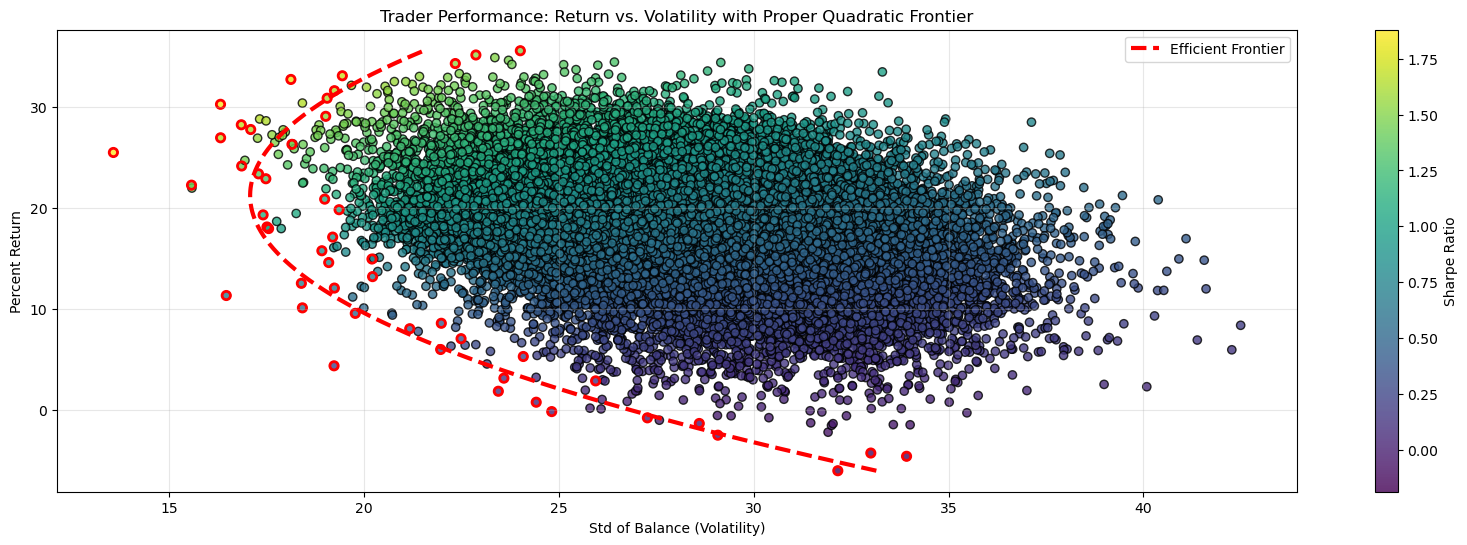

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Quadratic function for "sideways U" (Volatility as a function of Return)
def quadratic(y, a, b, c):
    return a * y**2 + b * y + c

plt.figure(figsize=(20, 6))
sc = plt.scatter(
    summary['Volatility'],
    summary['Return'],
    c=summary['Sharpe'],
    cmap='viridis',
    alpha=0.8,
    edgecolors='k'
)
cb = plt.colorbar(sc)
cb.set_label('Sharpe Ratio')

plt.xlabel('Std of Balance (Volatility)')
plt.ylabel('Percent Return')
plt.title('Trader Performance: Return vs. Volatility with Proper Quadratic Frontier')

# --- Corrected Efficient Frontier Calculation (Left-most boundary) ---
num_bins = 50  # More bins for smoother frontier
bin_edges = np.linspace(summary['Return'].min(), summary['Return'].max(), num_bins + 1)

# Bin by Return to explicitly pick minimum Volatility (leftmost points)
summary['ReturnBin'] = np.digitize(summary['Return'], bin_edges)

# Identify the leftmost point (minimum Volatility) per Return bin explicitly
frontier_points = (
    summary.groupby('ReturnBin')
    .apply(lambda df: df.loc[df['Volatility'].idxmin()])
    .reset_index(drop=True)
)

# Sort frontier points clearly
frontier_points = frontier_points.sort_values('Return')

# Remove any duplicates explicitly
frontier_points = frontier_points.drop_duplicates(subset=['Volatility', 'Return'])

# Fit quadratic polynomial (Volatility as a function of Return)
if len(frontier_points) >= 3:
    coeffs, _ = curve_fit(quadratic, frontier_points['Return'], frontier_points['Volatility'])

    # Generate smooth frontier curve
    y_smooth = np.linspace(frontier_points['Return'].min(), frontier_points['Return'].max(), 500)
    x_smooth = quadratic(y_smooth, *coeffs)

    # Plot explicitly the smooth quadratic efficient frontier
    plt.plot(x_smooth, y_smooth, color='red', linewidth=3, linestyle='--', label='Efficient Frontier')

    # Clearly highlight frontier points used in fitting
    plt.scatter(
        frontier_points['Volatility'],
        frontier_points['Return'],
        edgecolors='red',
        facecolors='none',
        linewidths=2
    )

plt.legend()
plt.grid(alpha=0.3)
plt.show()


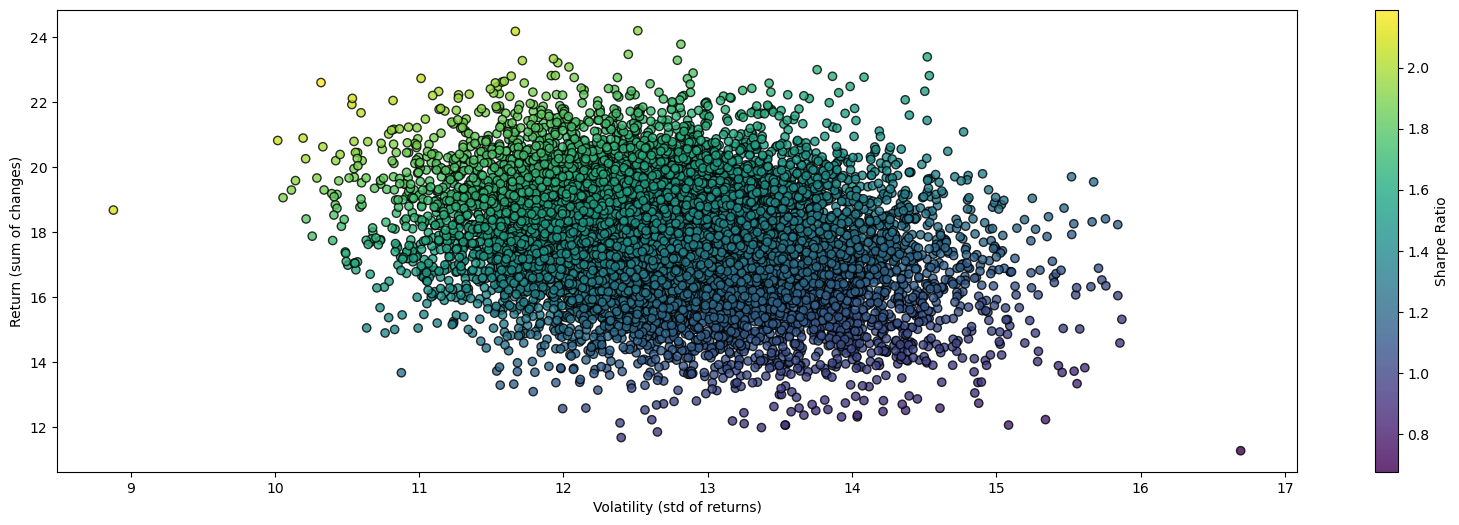

In [46]:
subdf = summary[summary["TraderType"] == "MarketMaker"]
fig = plt.figure(figsize=(20, 6))
plt.scatter(
    subdf["Volatility"]/2,
    subdf["Return"],
    c=subdf["Sharpe"]*2,
    cmap="viridis",
    alpha=0.8,
    edgecolor="k",
)

plt.xlabel("Volatility (std of returns)")
plt.ylabel("Return (sum of changes)")
plt.colorbar(label="Sharpe Ratio")
plt.grid(False)
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


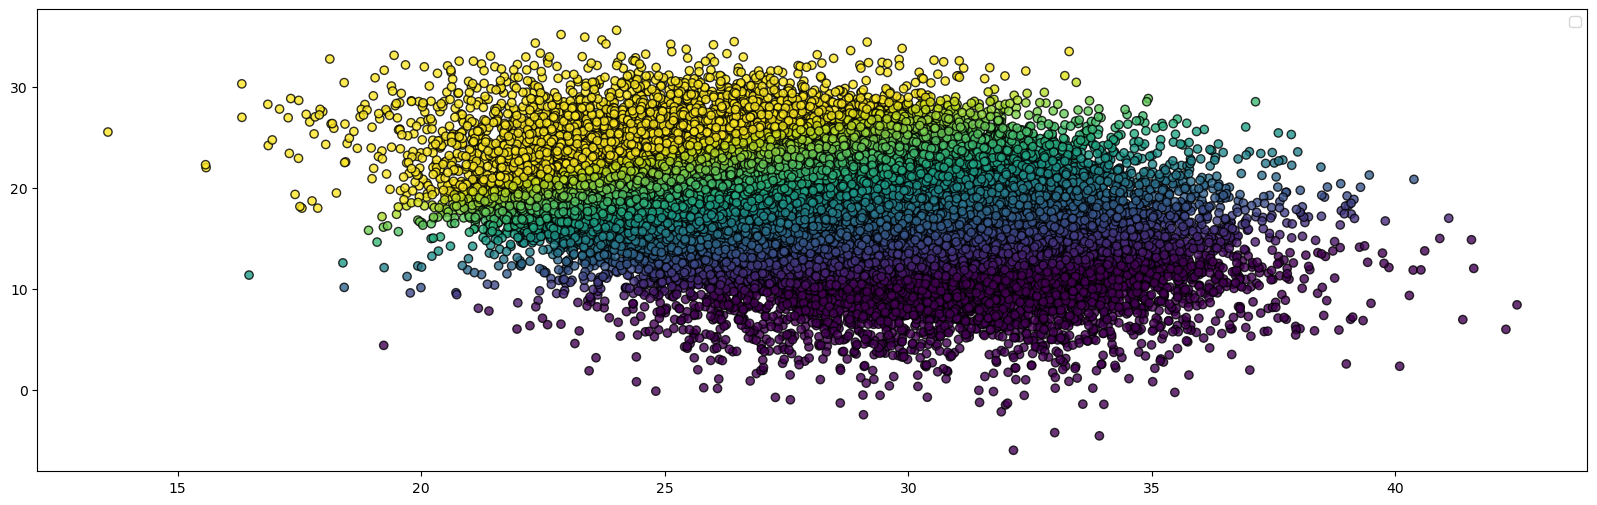

In [47]:
fig = plt.figure(figsize=(20, 6))
plt.scatter(
    summary["Volatility"],
    summary["Return"],
    c=summary["Sharpe"],
    cmap="viridis",
    alpha=0.8,
    edgecolor="k",
    vmin=vmin,
    vmax=vmax
)



plt.legend()

/Users/joshcable/anaconda3/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 38.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/joshcable/anaconda3/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 39.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/joshcable/anaconda3/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 29.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/joshcable/anaconda3/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 41.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/joshcable/anaconda3/lib/python3.10/site-packa

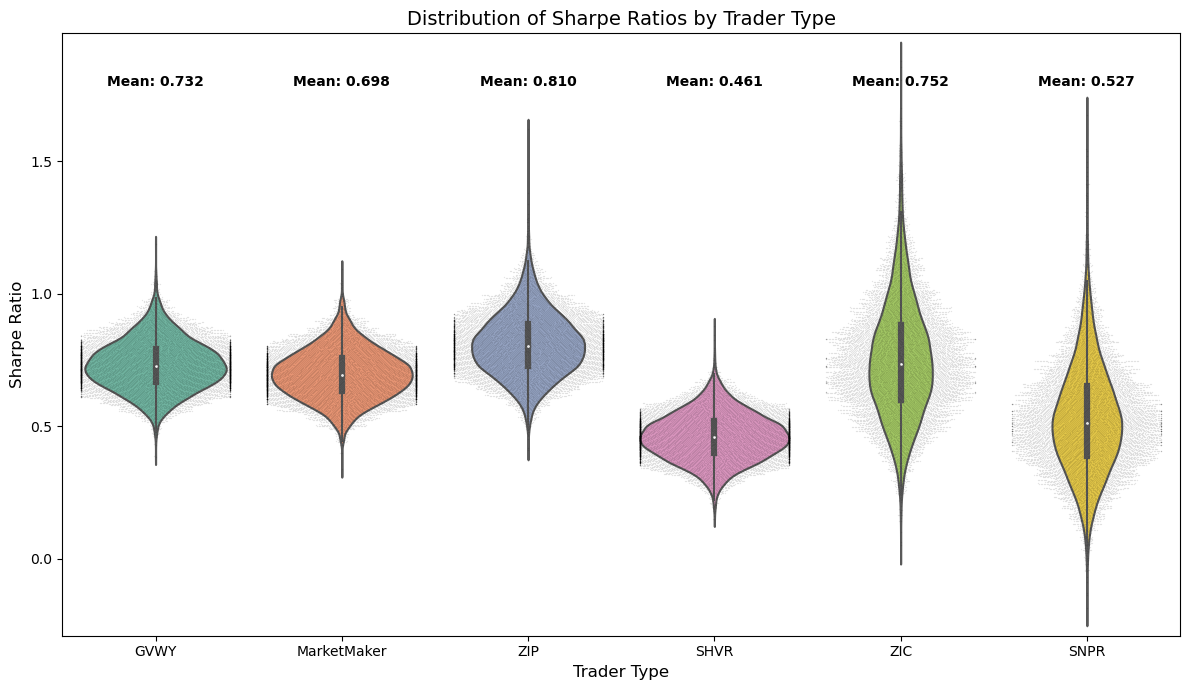

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 7))

# Create violin plot with overlaid boxplots
ax = sns.violinplot(x='TraderType', y='Sharpe', data=summary, 
                   palette='Set2', inner='box', order=sorted_traders)

# Add swarmplot for individual data points with small size and transparency
sns.swarmplot(x='TraderType', y='Sharpe', data=summary, color='black', 
             size=1, alpha=0.1, order=sorted_traders)

# Improve the appearance
plt.title('Distribution of Sharpe Ratios by Trader Type', fontsize=14)
plt.xlabel('Trader Type', fontsize=12)
plt.ylabel('Sharpe Ratio', fontsize=12)

# Add the mean values as text annotations
for i, trader in enumerate(sorted_traders):
    mean_sharpe = summary[summary['TraderType'] == trader]['Sharpe'].mean()
    ax.text(i, summary['Sharpe'].max() * 0.95, f'Mean: {mean_sharpe:.3f}', 
            ha='center', fontweight='bold')

plt.tight_layout()
plt.show()


F-statistic: 8628.198637937914
p-value: 0.0
Reject the null hypothesis - there are significant differences in Sharpe ratios between trader types

Tukey's HSD post-hoc test results:
     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
   group1      group2   meandiff p-adj  lower   upper  reject
-------------------------------------------------------------
       GVWY MarketMaker  -0.0335   0.0 -0.0395 -0.0275   True
       GVWY        SHVR  -0.2708   0.0 -0.2767 -0.2648   True
       GVWY        SNPR  -0.2042   0.0 -0.2102 -0.1982   True
       GVWY         ZIC   0.0201   0.0  0.0142  0.0261   True
       GVWY         ZIP   0.0785   0.0  0.0725  0.0844   True
MarketMaker        SHVR  -0.2373   0.0 -0.2432 -0.2313   True
MarketMaker        SNPR  -0.1707   0.0 -0.1767 -0.1647   True
MarketMaker         ZIC   0.0536   0.0  0.0477  0.0596   True
MarketMaker         ZIP    0.112   0.0   0.106  0.1179   True
       SHVR        SNPR   0.0666   0.0  0.0606  0.0725   True
       SHVR  

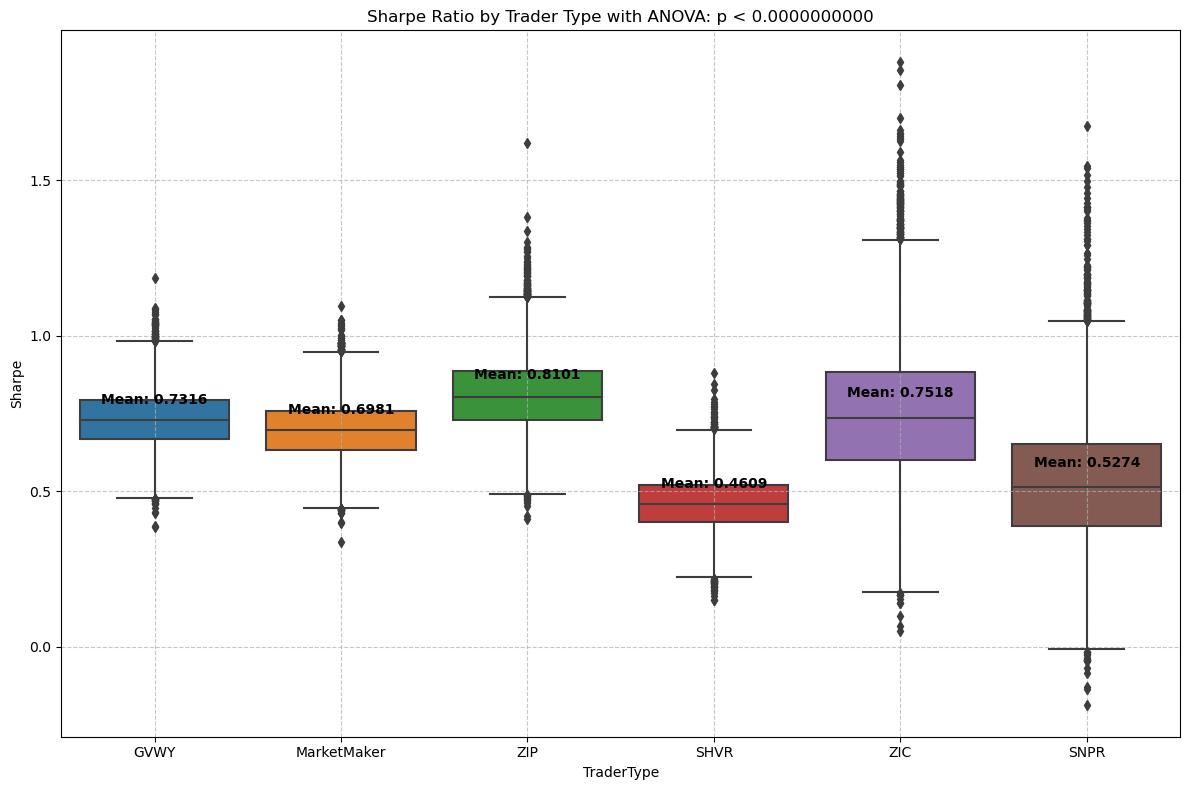

In [49]:
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd

import scipy.stats as stats
import matplotlib.pyplot as plt

# Perform one-way ANOVA
# Create a list of Sharpe ratio groups (one group per trader type)
sharpe_groups = [summary[summary['TraderType'] == trader]['Sharpe'] for trader in summary['TraderType'].unique()]

# Run the ANOVA test
f_stat, p_value = stats.f_oneway(*sharpe_groups)

print(f"F-statistic: {f_stat}")
print(f"p-value: {p_value}")

# Interpret the result
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis - there are significant differences in Sharpe ratios between trader types")
else:
    print("Fail to reject the null hypothesis - no significant differences detected")

# If the ANOVA is significant, perform post-hoc tests to see which pairs differ
if p_value < alpha:
    
    # Prepare data for Tukey's test
    data = summary['Sharpe']
    groups = summary['TraderType']
    
    # Perform Tukey's test
    tukey_results = pairwise_tukeyhsd(data, groups, alpha=0.05)
    print("\nTukey's HSD post-hoc test results:")
    print(tukey_results)
    
    # Create a more informative boxplot
    plt.figure(figsize=(12, 8))
    ax = sns.boxplot(x='TraderType', y='Sharpe', data=summary, order=sorted_traders)
    
    # Add mean markers
    for i, trader in enumerate(sorted_traders):
        mean_val = summary[summary['TraderType'] == trader]['Sharpe'].mean()
        ax.text(i, mean_val + 0.05, f'Mean: {mean_val:.4f}', ha='center', fontweight='bold')
    
    plt.title('Sharpe Ratio by Trader Type with ANOVA: p < {:.10f}'.format(p_value))
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'sorted_traders' contains a sorted list of unique TraderType values
# For example:
# sorted_traders = sorted(summary['TraderType'].unique())

# Figure 1: Violin plot with jittered swarmplot overlay
plt.figure(figsize=(14, 8))

sns.swarmplot(
    x='TraderType', 
    y='Sharpe', 
    data=summary, 
    size=6, 
    edgecolor="k",
    order=sorted_traders
)

plt.title('Distribution of Sharpe Ratios by Trader Type')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



/Users/joshcable/anaconda3/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 96.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/joshcable/anaconda3/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 96.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/joshcable/anaconda3/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 95.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/joshcable/anaconda3/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 96.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/joshcable/anaconda3/lib/python3.10/site-packa

KeyboardInterrupt: 

In [ ]:
# Figure 2: Density (KDE) plots for each trader type
plt.figure(figsize=(8, 8))
for trader in sorted_traders:
    subset = summary[summary['TraderType'] == trader]
    sns.kdeplot(
        subset['Sharpe'],
        label=trader
    )
    
plt.title('Density Plot of Sharpe Ratios by Trader Type')
plt.legend(title='Trader Type')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

NameError: name 'sorted_traders' is not defined

<Figure size 800x800 with 0 Axes>

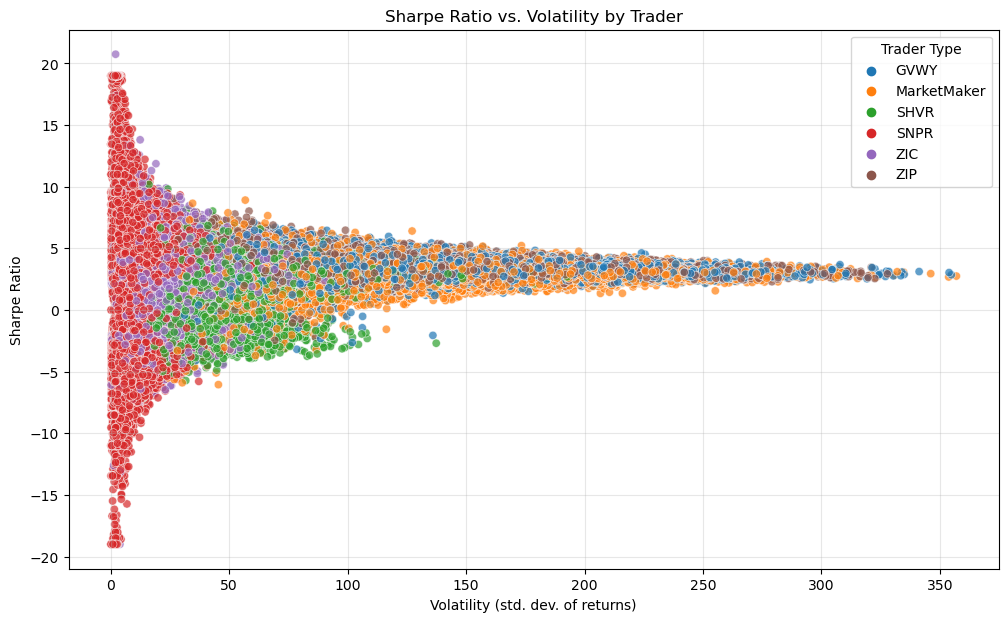

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,7))
sns.scatterplot(
    data=summary,
    x="Volatility",
    y="Sharpe",
    hue="TraderType",
    palette="tab10",
    alpha=0.7
)
plt.xlabel("Volatility (std. dev. of returns)")
plt.ylabel("Sharpe Ratio")
plt.title("Sharpe Ratio vs. Volatility by Trader")
plt.grid(True, alpha=0.3)
plt.legend(title="Trader Type")
plt.show()
